In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import scipy
import mne
import os
import pandas as pd
import numpy as np
import mne
import scipy
import pickle

In [2]:
PATH_TROUGHS = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\SharpWaveAnalysis\\"
PATH_PEAKS = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\SharpWaveAnalysis_Peaks\\"
PATH_SAVE = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\SharpWaveAnalysis\\preprocessed\\"
PATH_COMBINED = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\Combined_runs\\"

In [3]:
dict_metrics_TROUGH = {"sharpness":"mV", 
                        "trough":"mV",
                        "interval":"ms",
                        "prominence":"mV",
                        "rise_steepness":"mV'",
                        "rise_time":"ms", 
                        "decay_steepness":"mV'",
                        "slope_ratio":"mV'",
                        "decay_time":"ms",
                        "width":"ms"}

dict_metrics_PEAK = {"sharpness":"mV", 
                "trough":"mV",
                "interval":"ms",
                "prominence":"mV",
                "rise_steepness":"mV'",
                "rise_time":"ms", 
                "decay_steepness":"mV'",
                "slope_ratio":"mV'",
                "decay_time":"ms",
                "width":"ms"}


def plot_mov_sep_hist(metric, label):
    sn.distplot(df[df.MOV_TYPE.str.contains("NONE")][metric], label='None', color='black')
    sn.distplot(df[df.MOV_TYPE.str.contains("CON")][metric], label='CON', color='red')
    sn.distplot(df[df.MOV_TYPE.str.contains("IPS")][metric], label='IPS', color='blue')
    plt.title(metric)
    plt.xlabel(metric + " [" + label+"]")
    plt.legend()
    
def plot_hist_comp(metric, metric_unit, df):
    p = np.array(df[df.MOV_TYPE.str.contains("NO_MOV")][metric])
    q_con = np.array(df[df.MOV_TYPE.str.contains("CON")][metric])
    q_ips = np.array(df[df.MOV_TYPE.str.contains("IPS")][metric])

    range_ = [np.min(np.concatenate([q_con, q_ips, p])), np.max(np.concatenate([q_con, q_ips, p]))]
    p_, x, _ = plt.hist(p, density=True, bins=50, range=range_, alpha=0.3, color="black")
    q_con_ = plt.hist(q_con, density=True, bins=50, range=range_, alpha=0.3, color="r")[0]
    # for Dkl replace zero elements with e-9
    Dkl_con = np.round(scipy.stats.entropy(np.where(p_ == 0.0, 1e-9, p_), np.where(q_con_ == 0.0, 1e-9, q_con_)), 2)
    
    # adapt this measure 
    
    q_ips_ = plt.hist(q_ips, density=True, bins=50, range=range_, alpha=0.3, color="b")[0]
    Dkl_ips = np.round(scipy.stats.entropy(np.where(p_ == 0.0, 1e-9, p_), np.where(q_ips_ == 0.0, 1e-9, q_ips_)), 2)


    density_p = scipy.stats.gaussian_kde(p)
    density_q_con = scipy.stats.gaussian_kde(q_con)
    density_q_ips = scipy.stats.gaussian_kde(q_ips)
    plt.plot(x, density_p(x), c="black", label='NO_MOV')
    plt.plot(x, density_q_con(x), c="r", label='CON')
    plt.plot(x, density_q_ips(x), c="b", label='IPS')
    plt.legend()

    plt.title("Dkl_con = " + str(Dkl_con)+ "\nDkl_ips = "+ str(Dkl_ips))
    plt.xlabel(metric + " ["+ metric_unit+"]")
    return Dkl_con, Dkl_ips

def get_sharpness_ratio(df_PEAKS, df_TROUGHS, MOV_TYPE):
    df_PEAKS_ = df_PEAKS[df_PEAKS.MOV_TYPE == MOV_TYPE]
    df_TROUGHS_ = df_TROUGHS[df_TROUGHS.MOV_TYPE == MOV_TYPE]
    
    sharpness_tr = np.sum(df_TROUGHS_["sharpness"]) / df_TROUGHS_["sharpness"].shape[0]
    sharpness_pe = np.sum(df_PEAKS_["sharpness"]) / df_PEAKS_["sharpness"].shape[0]
    sharpness_ratio = np.max([sharpness_pe/sharpness_tr, sharpness_tr/sharpness_pe])
    
    return sharpness_ratio

class NoValidTroughException(Exception):
    pass

In [4]:
files_combined = os.listdir(PATH_COMBINED)
files_peaks = os.listdir(PATH_PEAKS)

### ECOG sharpness

In [5]:
loc = "ECOG"

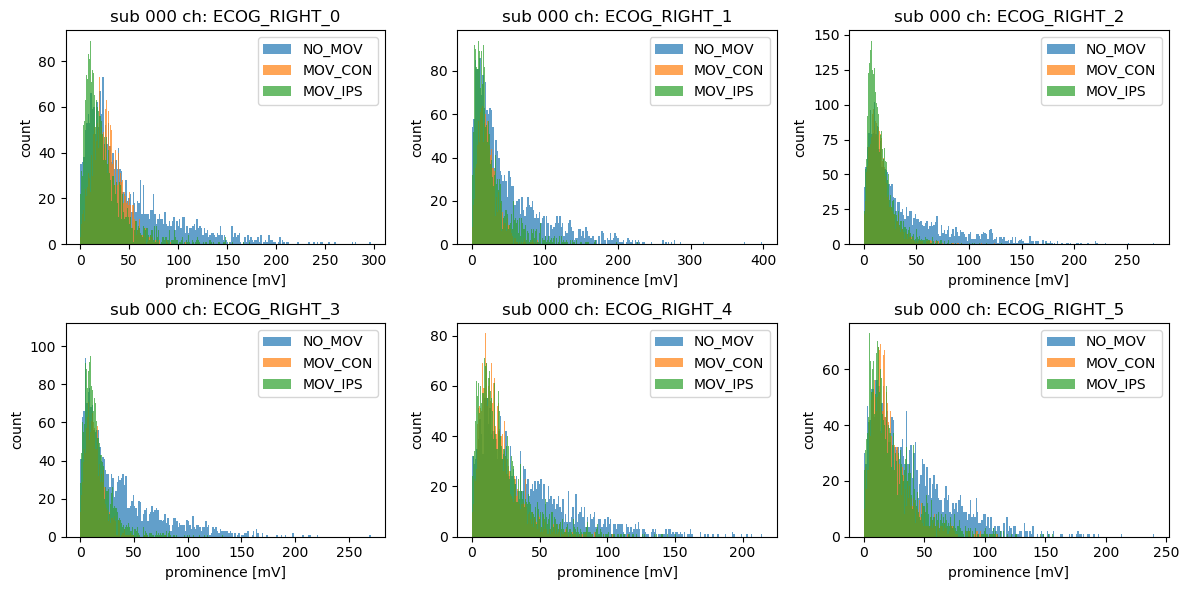

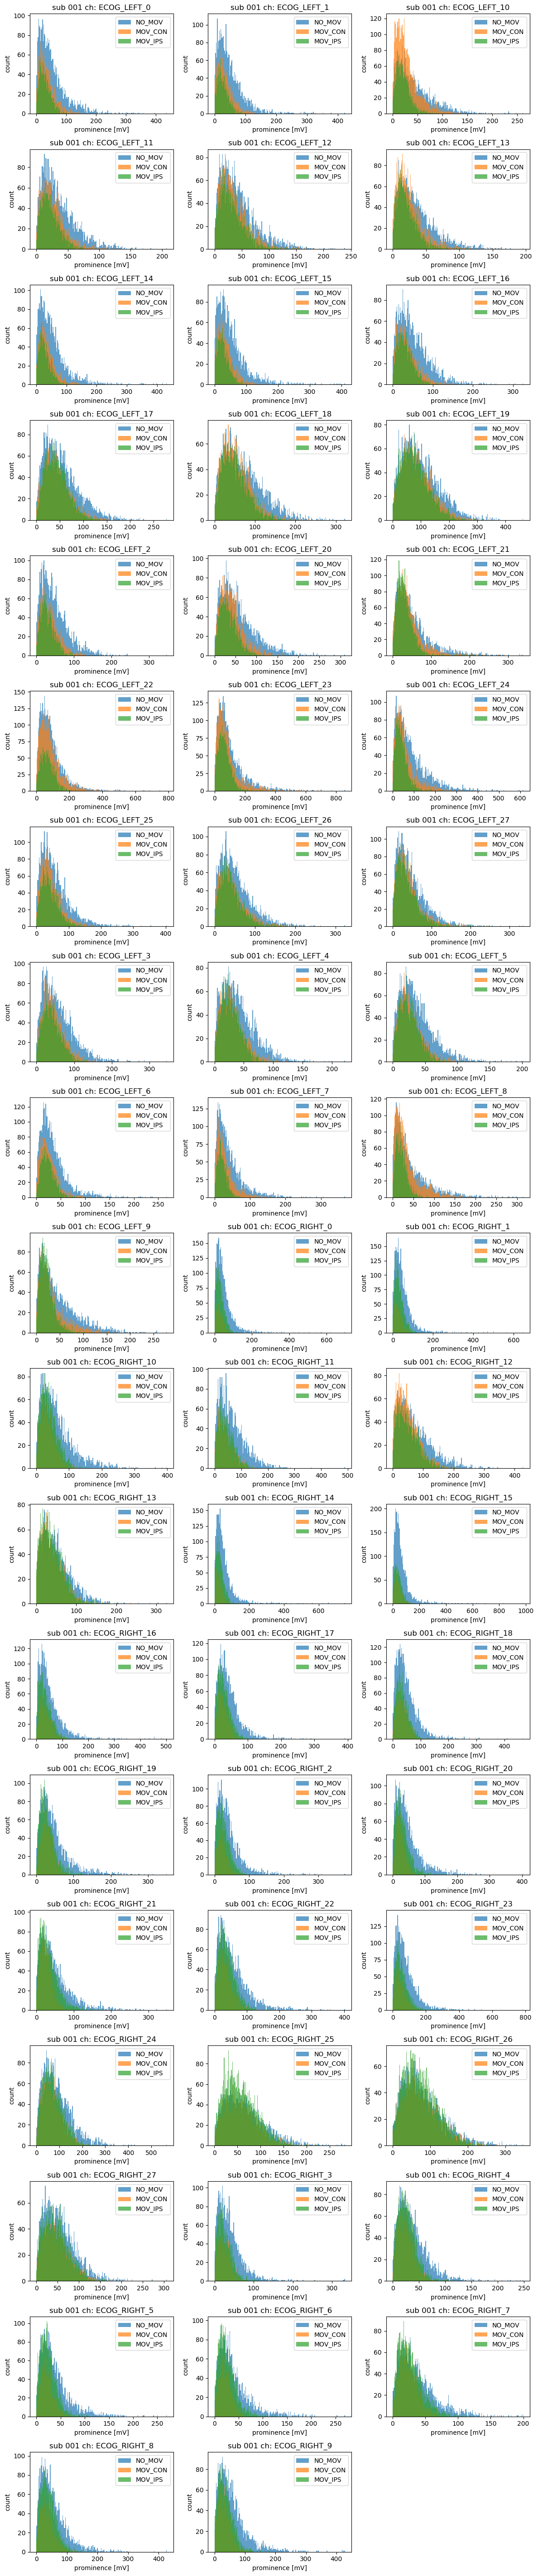

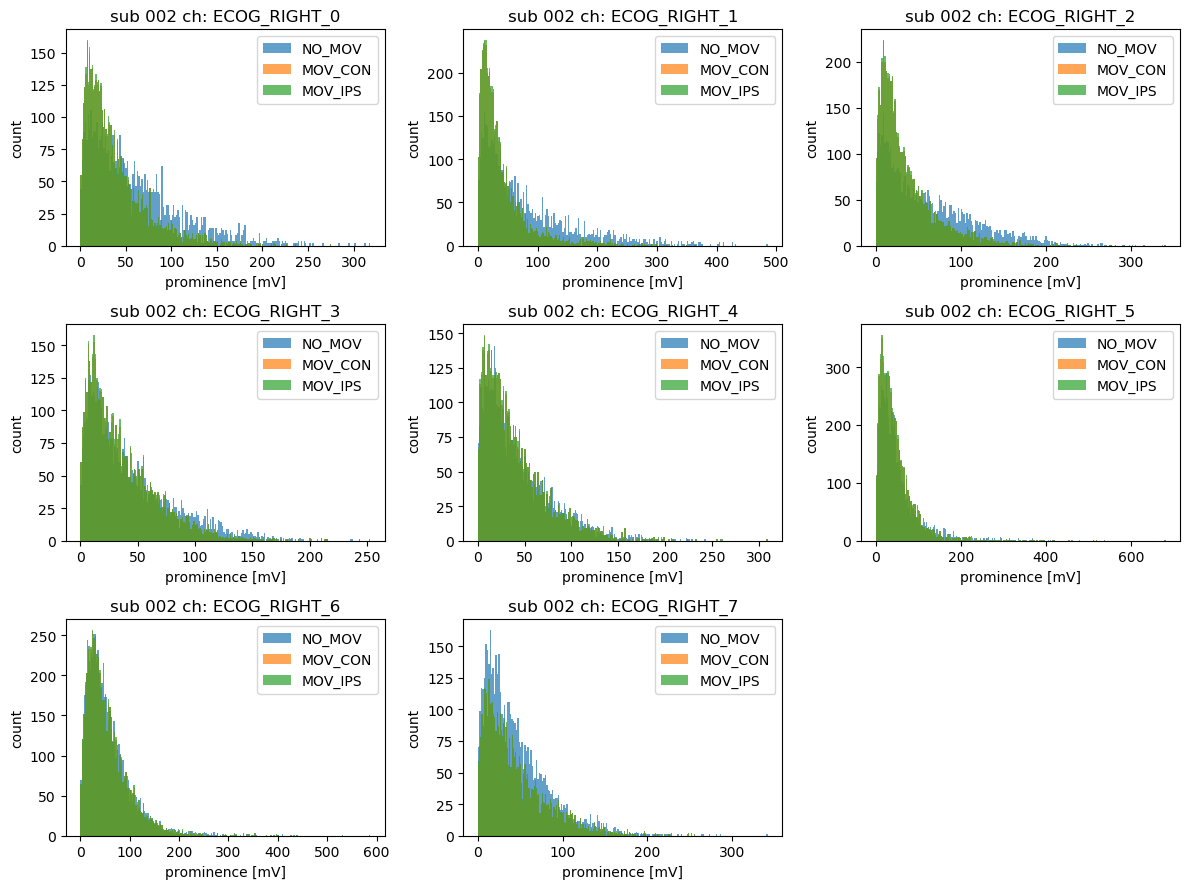

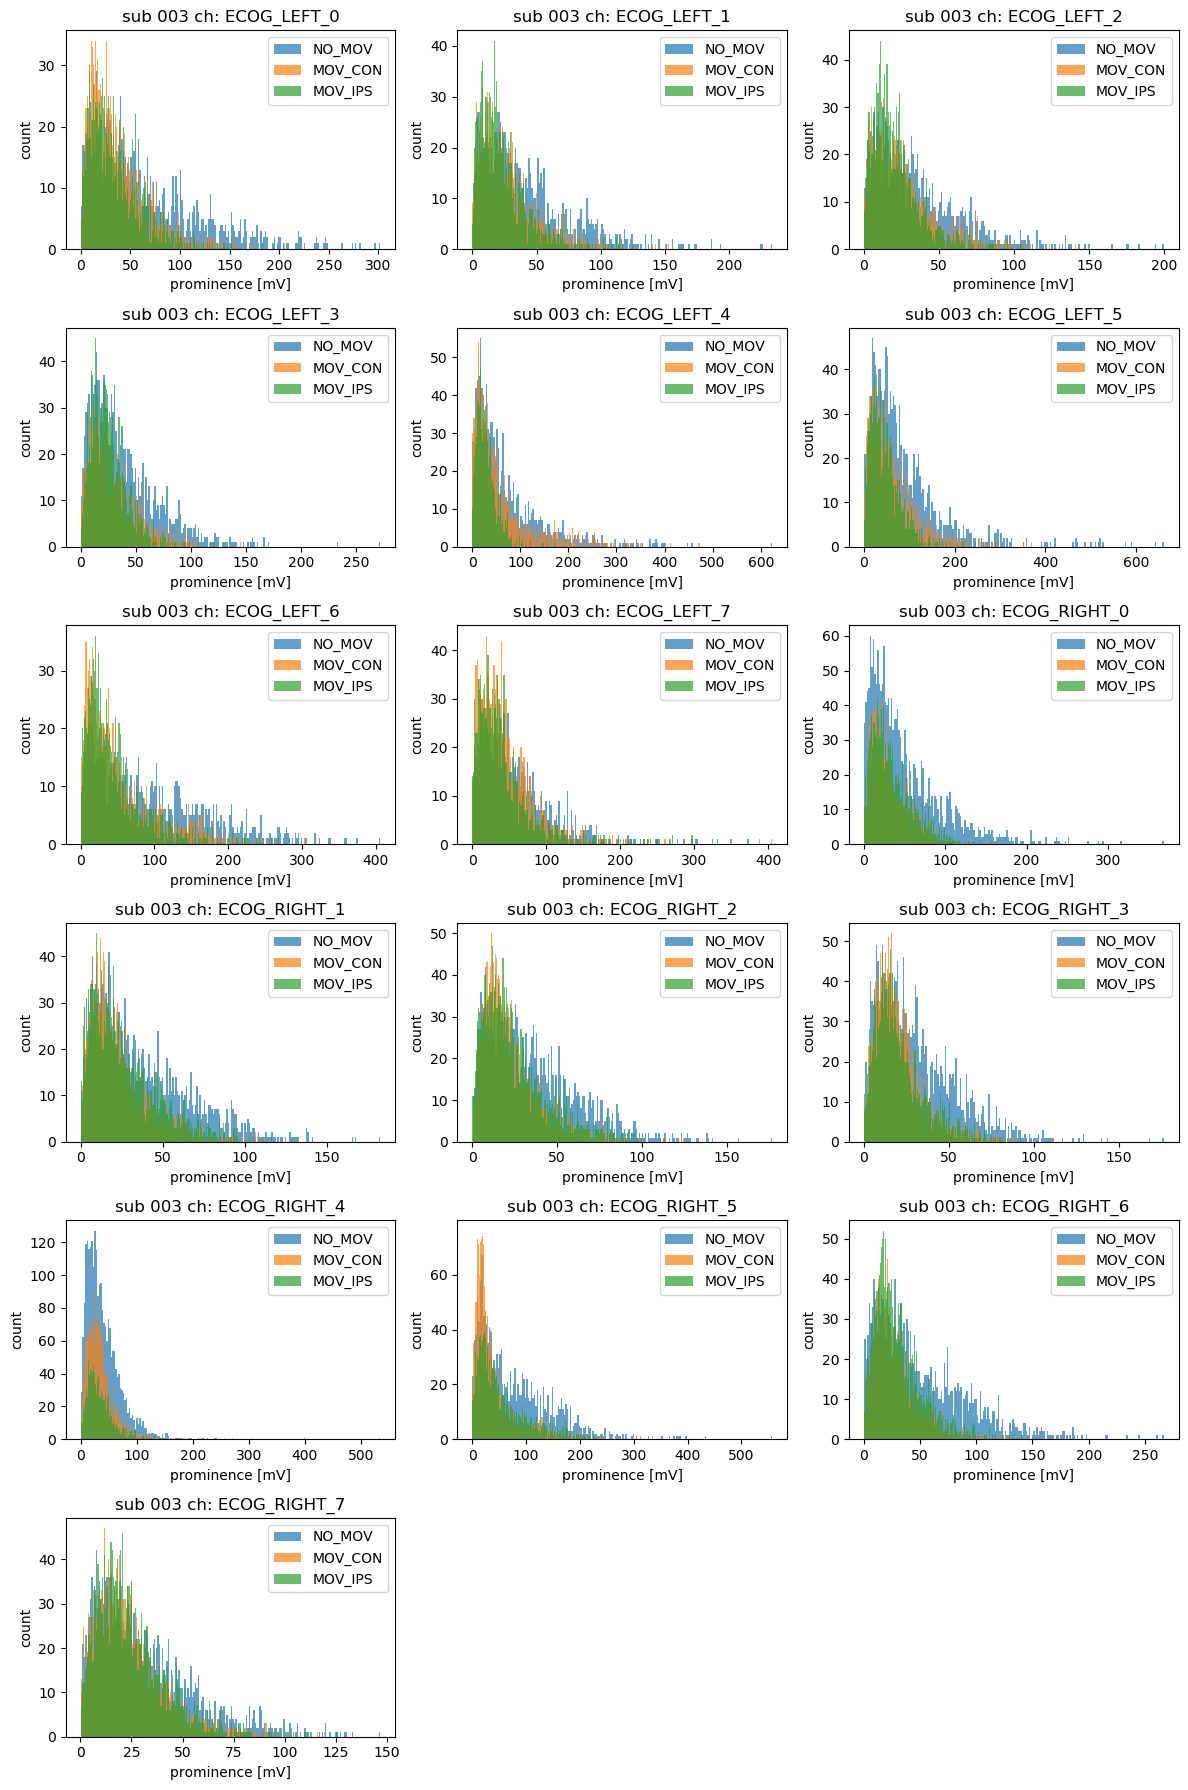

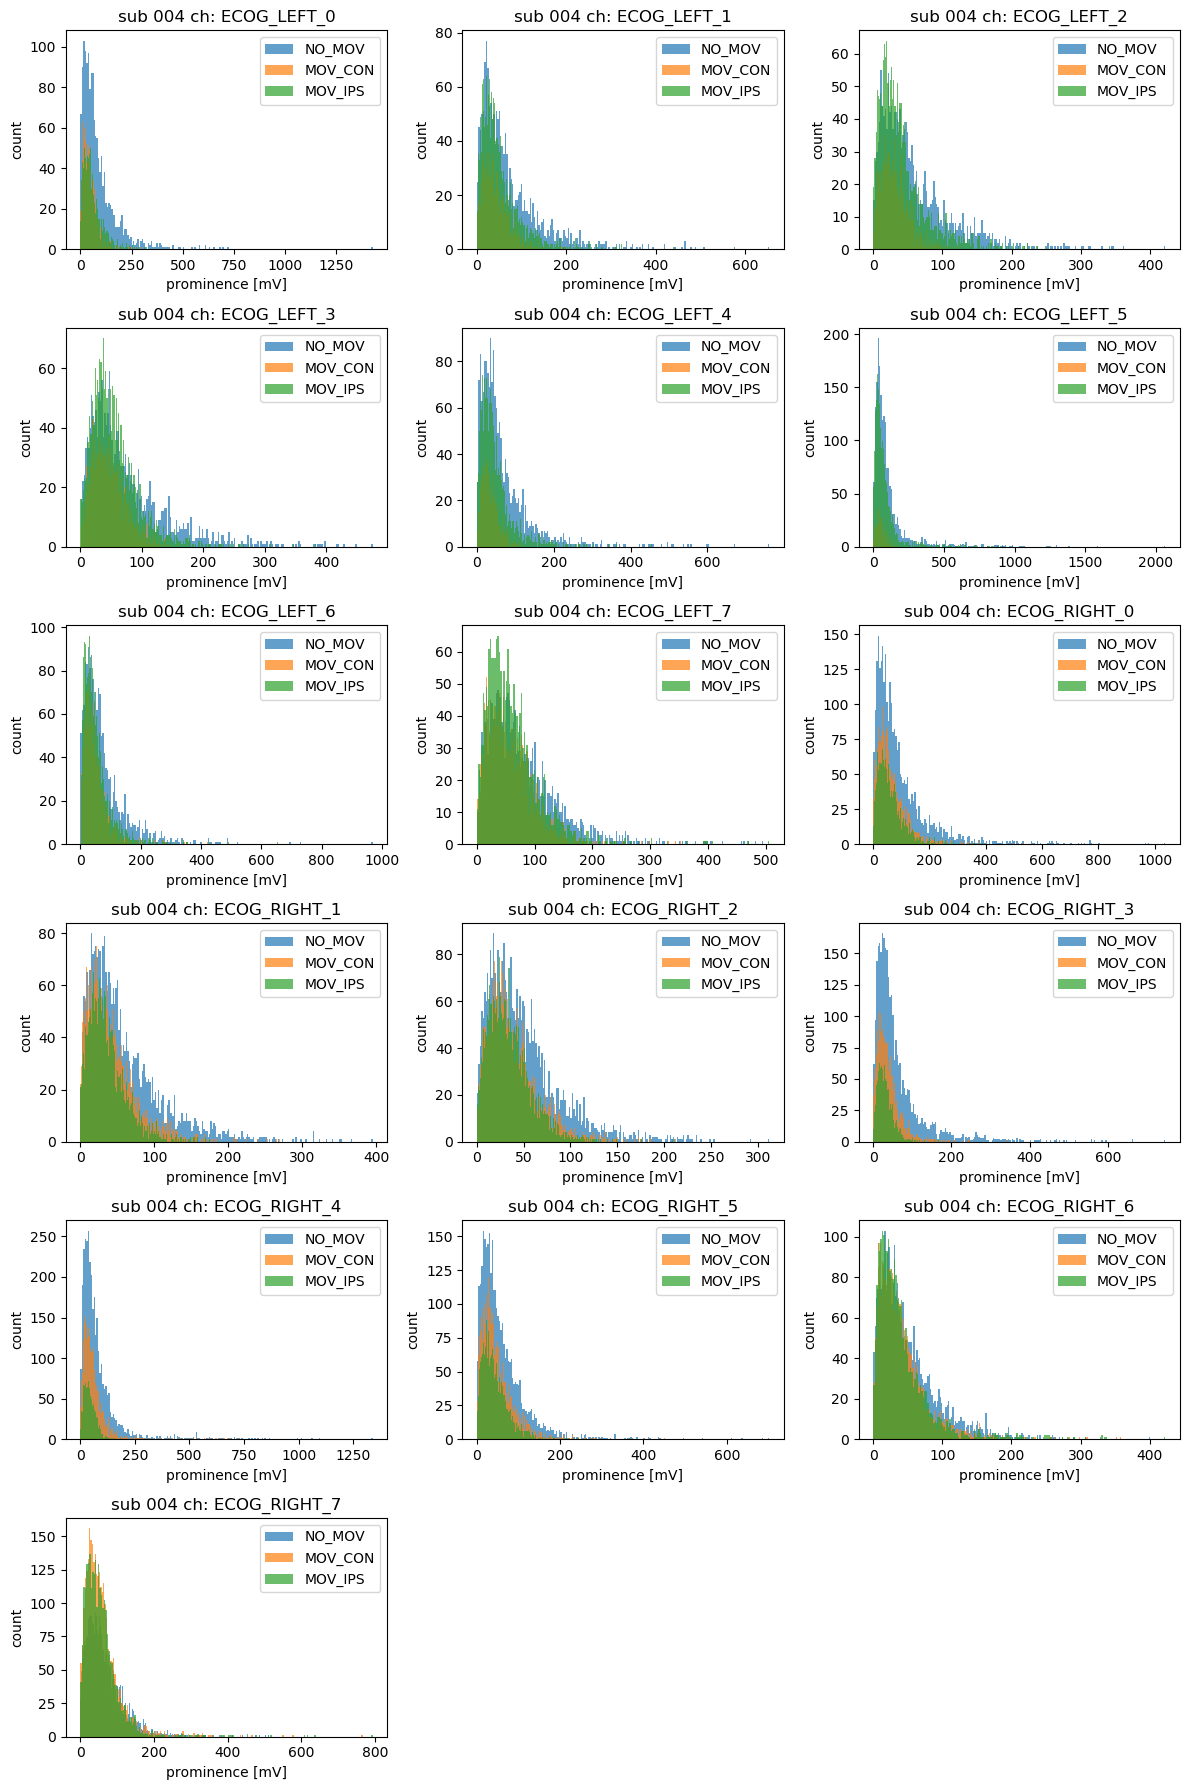

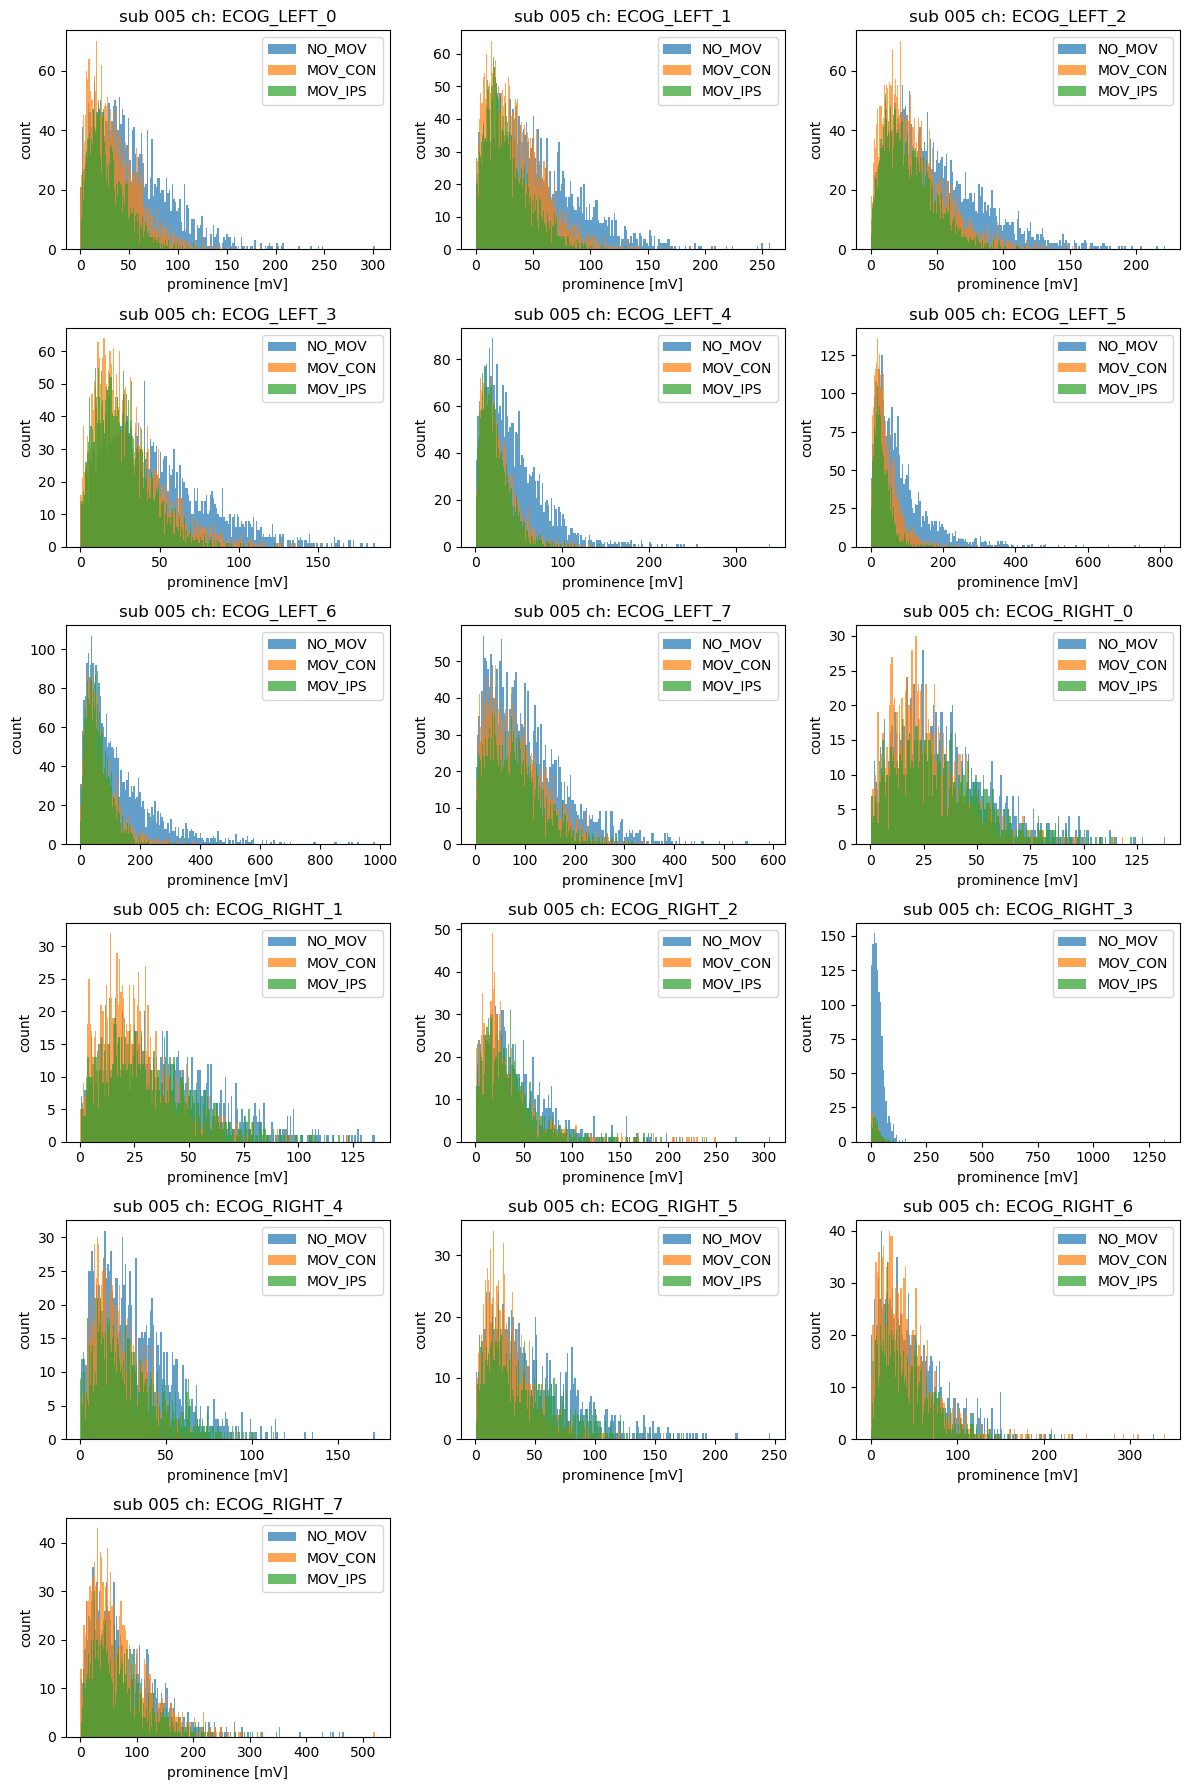

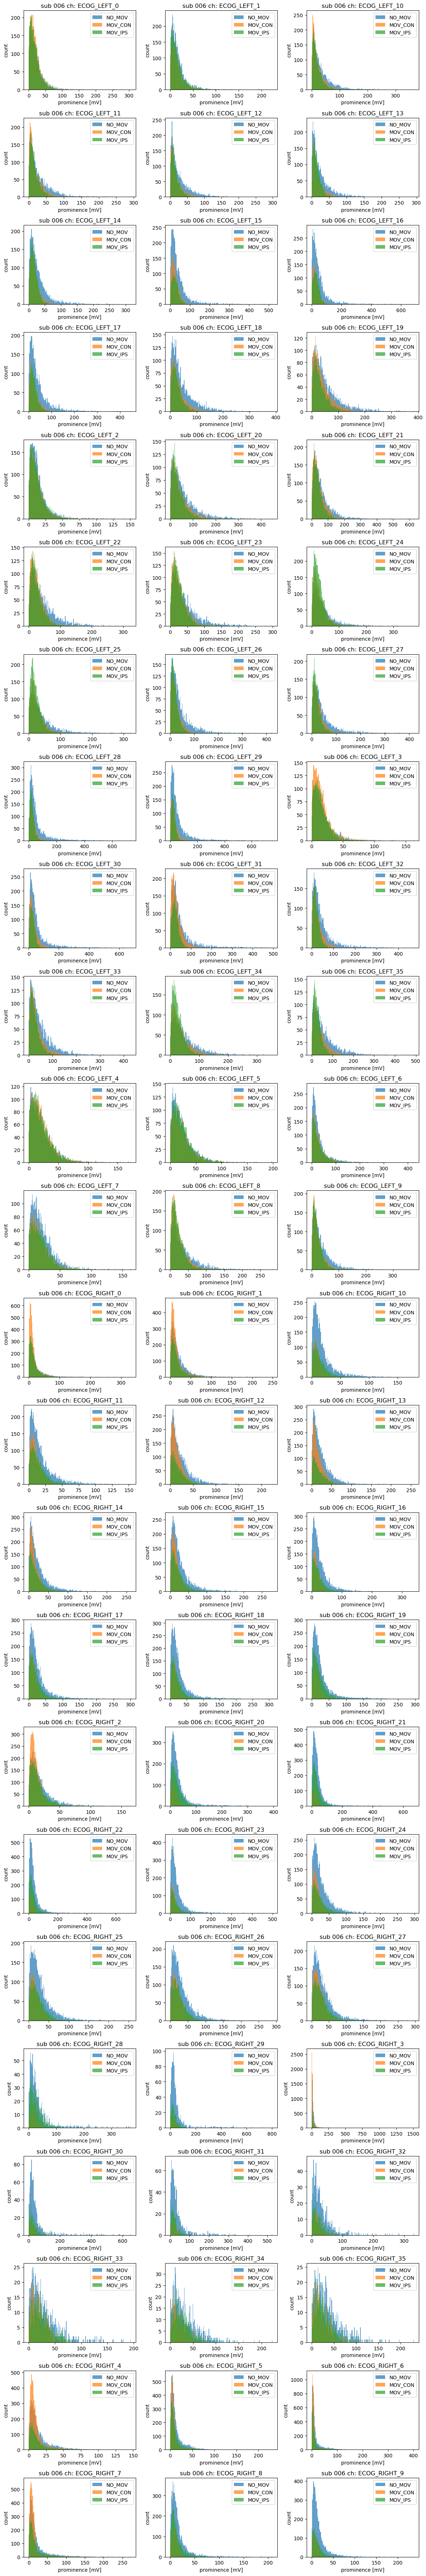

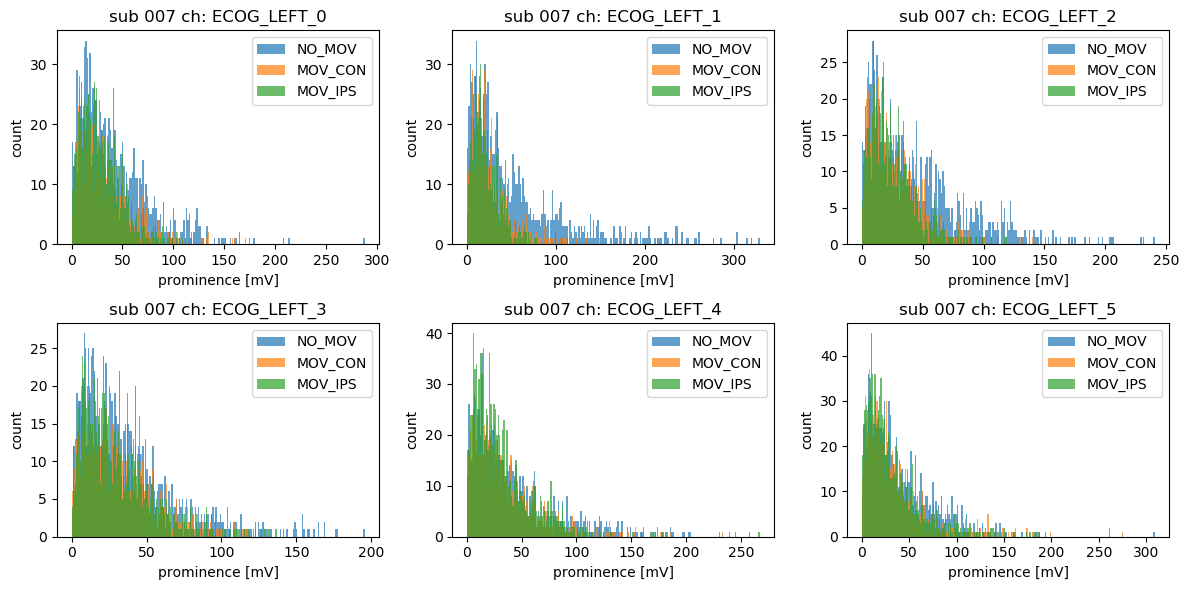

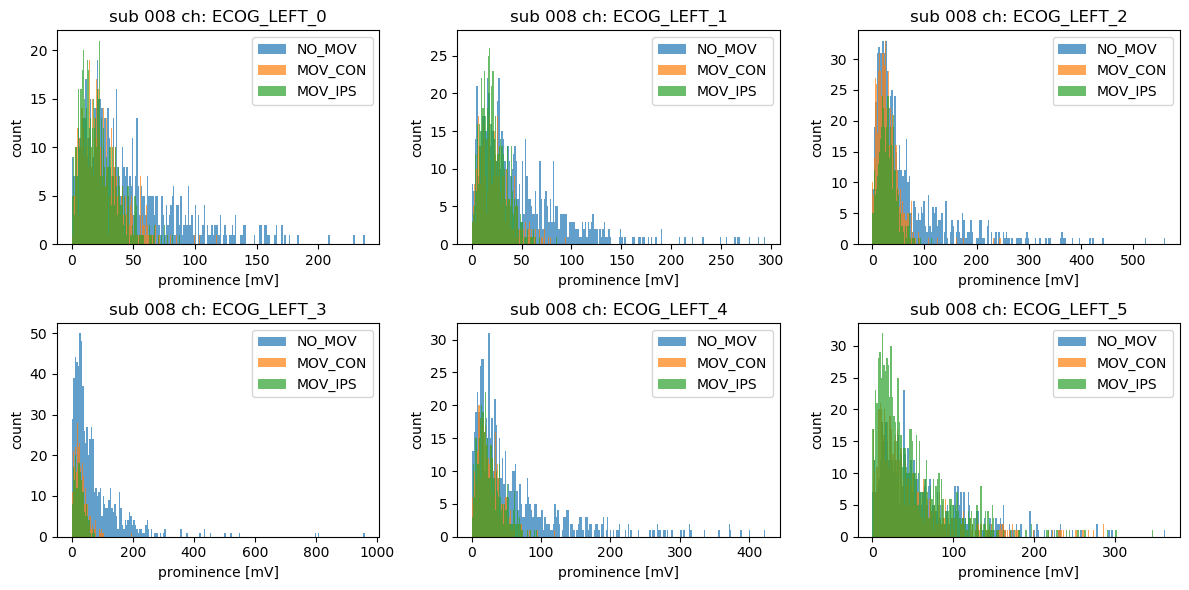

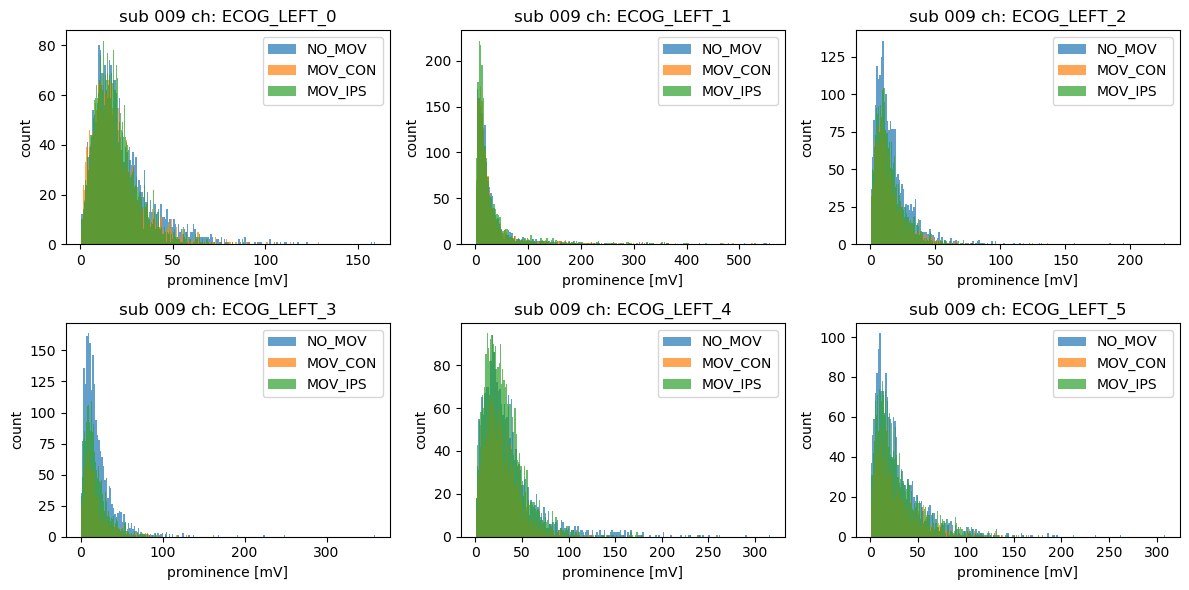

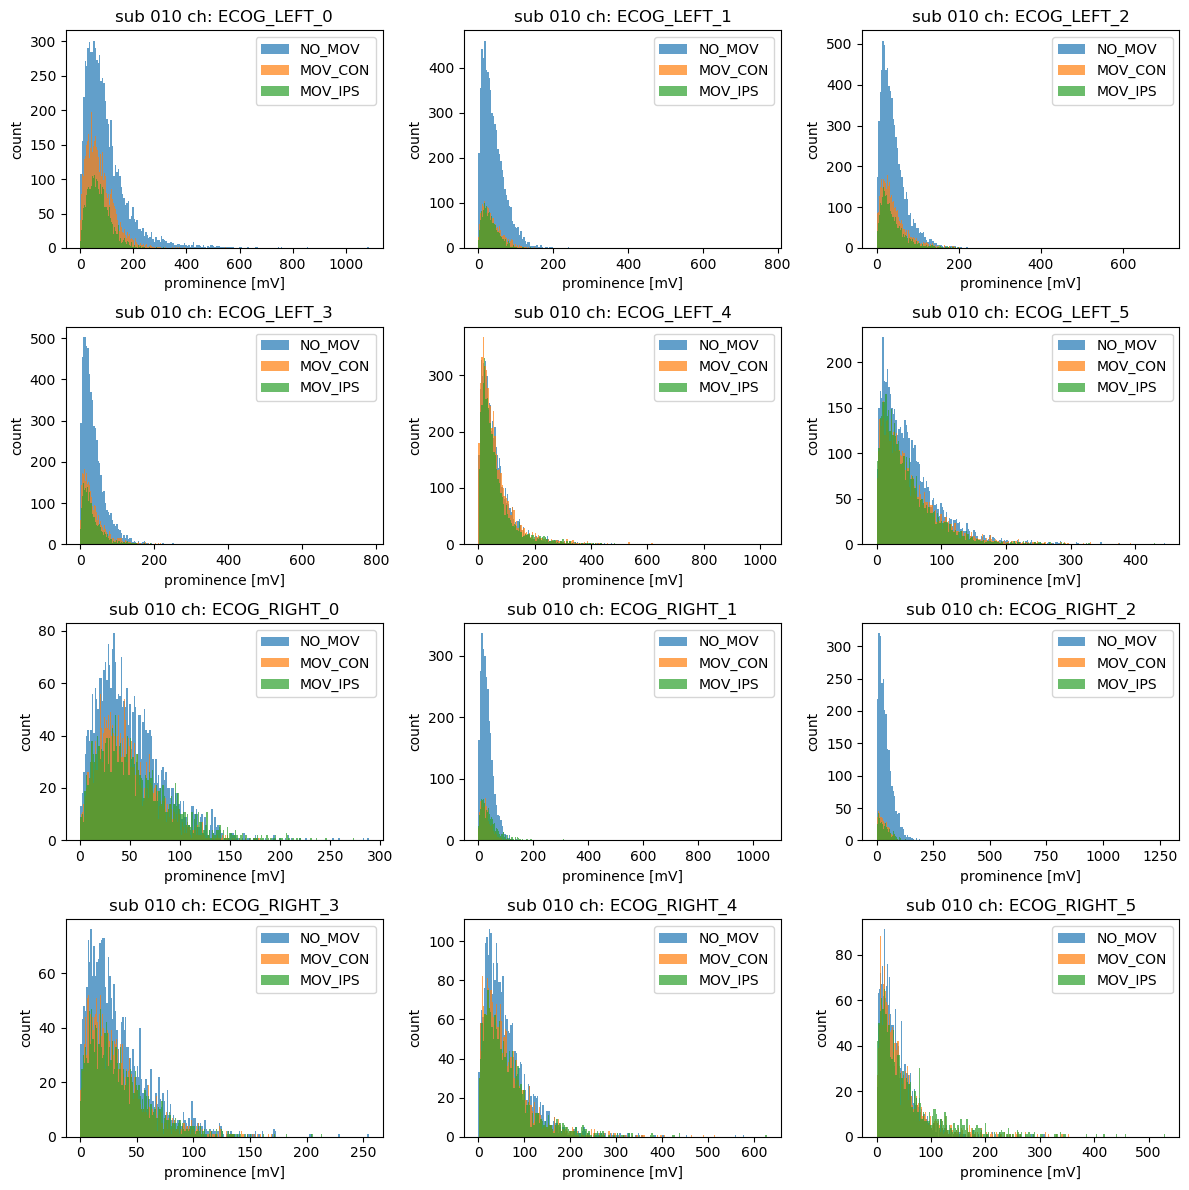

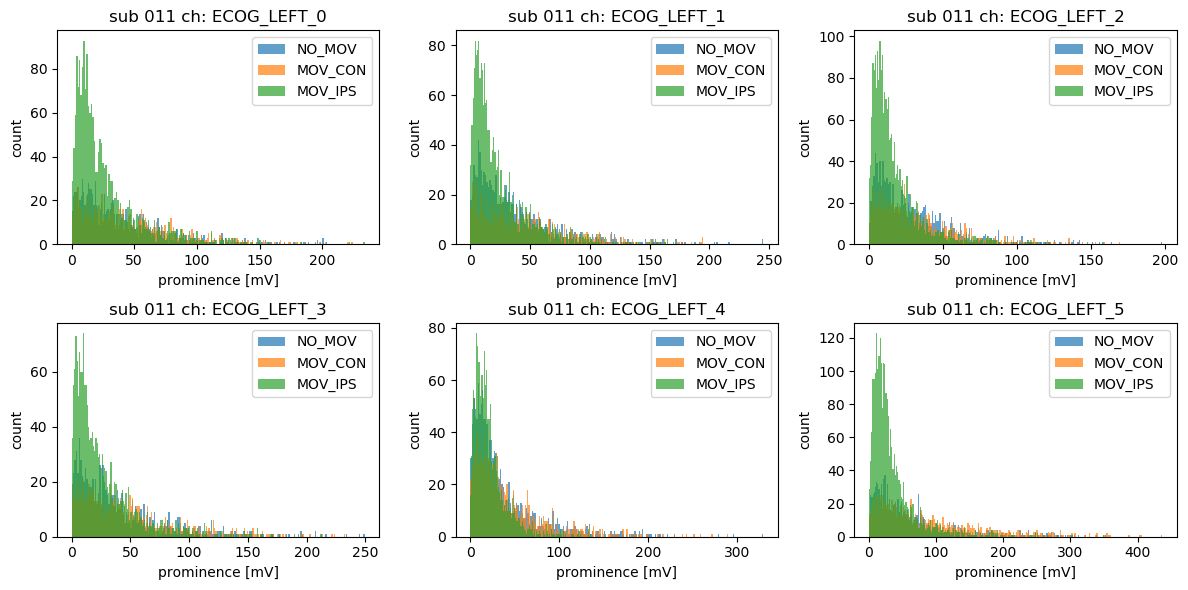

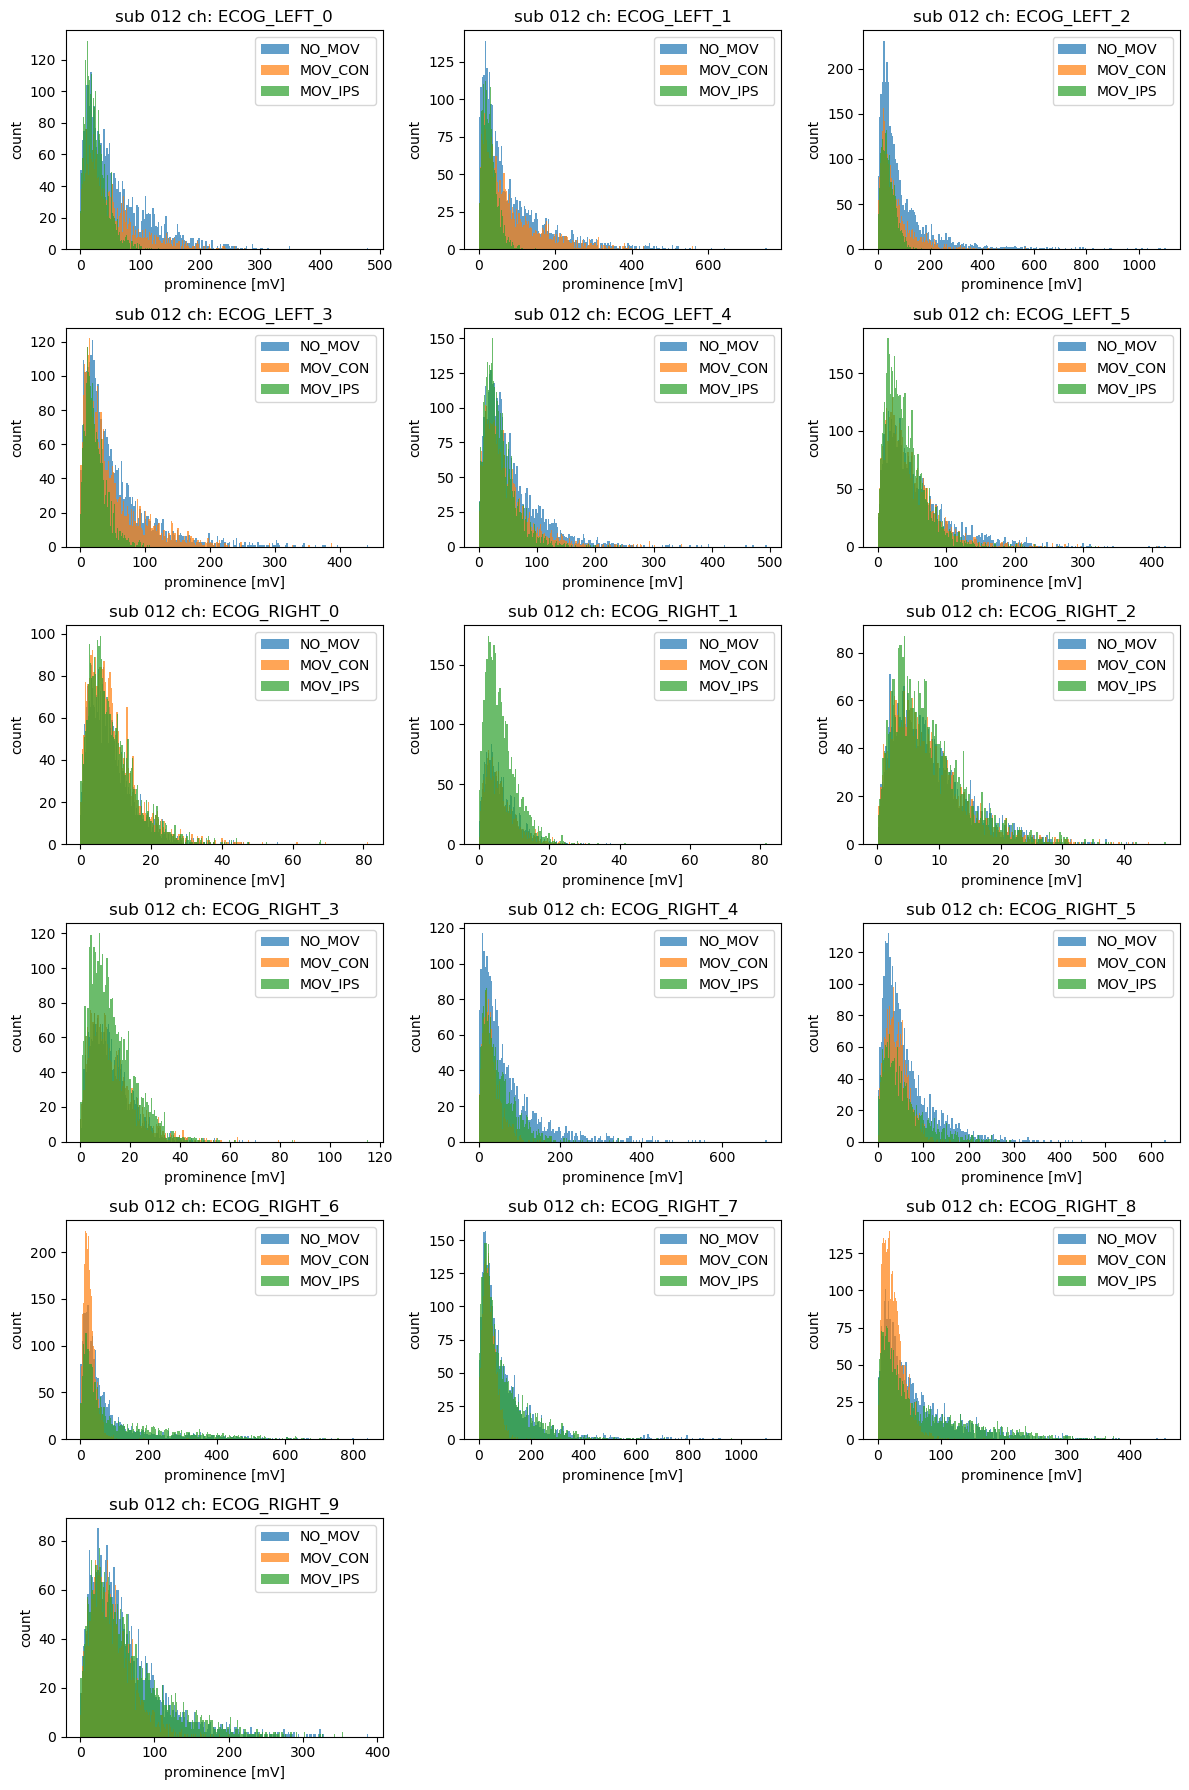

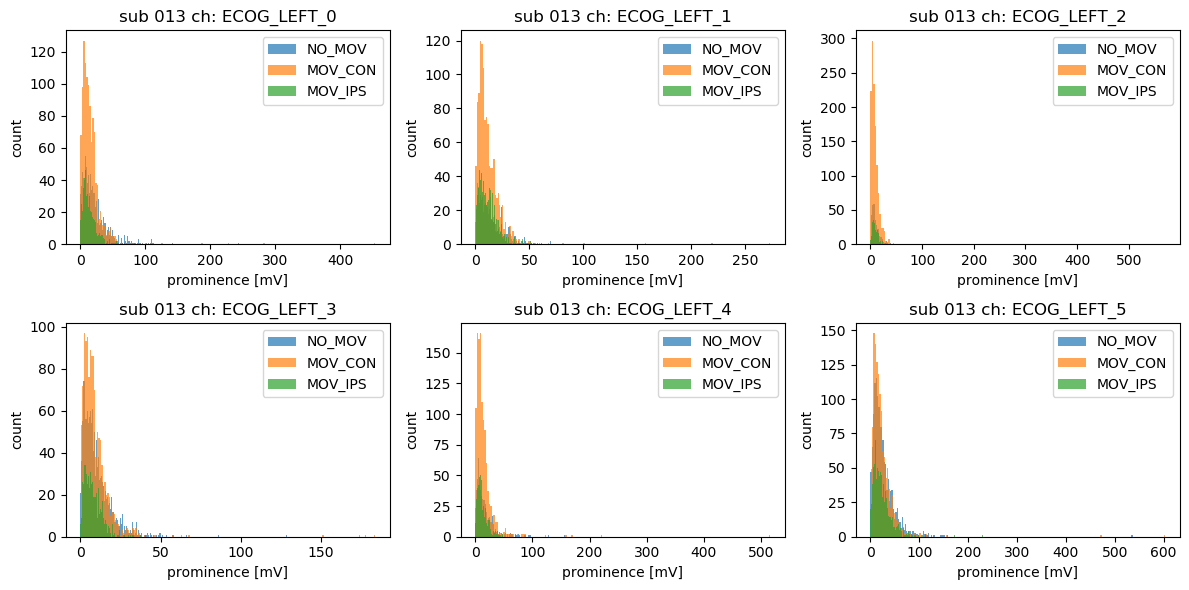

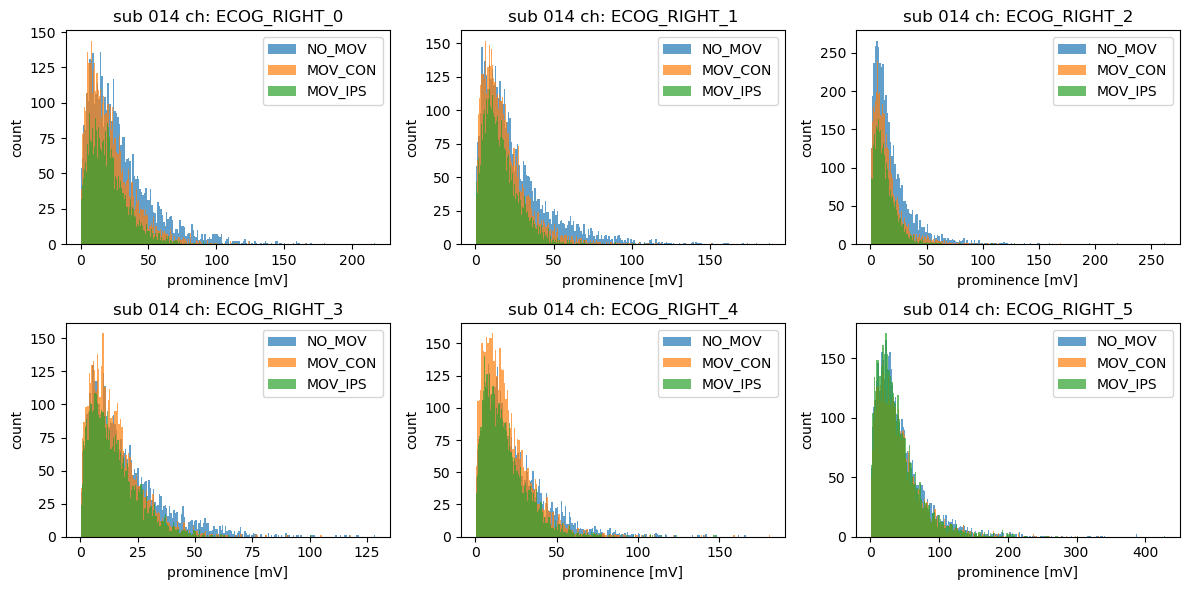

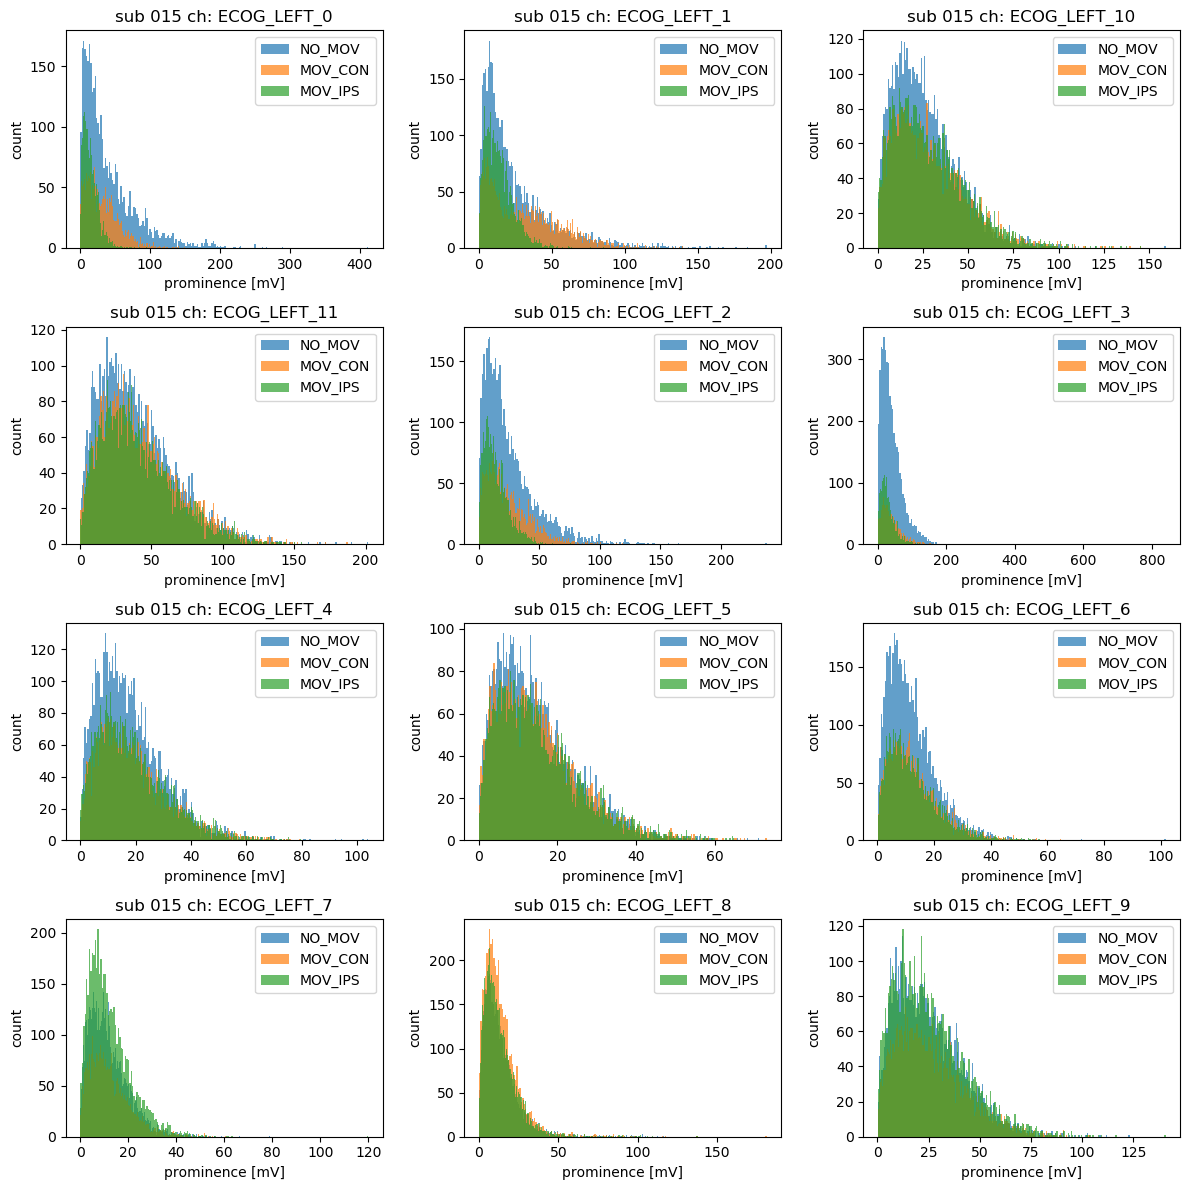

In [19]:
subjects = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']
for sub in subjects:
    res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
    files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))
    num_rows = np.ceil(files.shape[0]/3)
    plt.figure(figsize=(12,num_rows*3), dpi=100)
    for idx, f in enumerate(files):
        plt.subplot(num_rows,3,idx+1)
        ch_ = f[11:-2]
        downsample_factor = int(1/(np.where(res[ch_]["mov_con"]>0)[0].shape[0] / \
                            np.where((res[ch_]["mov_con"]==0) & (res[ch_]["mov_ips"]==0))[0].shape[0]))

        df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, f), allow_pickle=True)
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("NO_MOV")]["prominence"][::downsample_factor], 
                 bins=200, alpha=0.7, label="NO_MOV")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("CON")]["prominence"], bins=200, alpha=0.7, label="MOV_CON")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("IPS")]["prominence"], bins=200, alpha=0.7, label="MOV_IPS")
        plt.legend()
        plt.xlabel('prominence [mV]')
        plt.ylabel("count")
        plt.title("sub "+str(sub)+ " ch: "+ str(ch_))
    plt.tight_layout()
    plt.show()

### STN sharpness

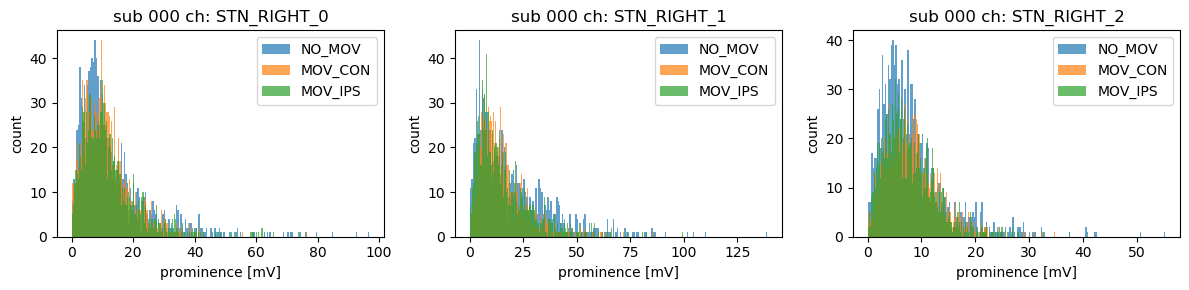

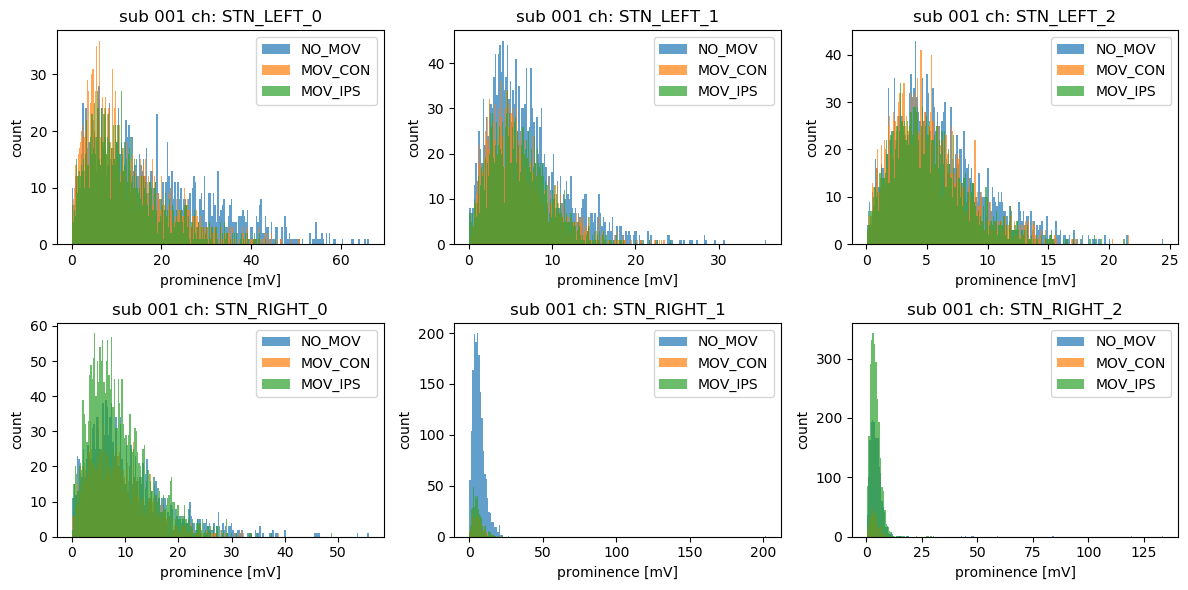

<Figure size 1200x0 with 0 Axes>

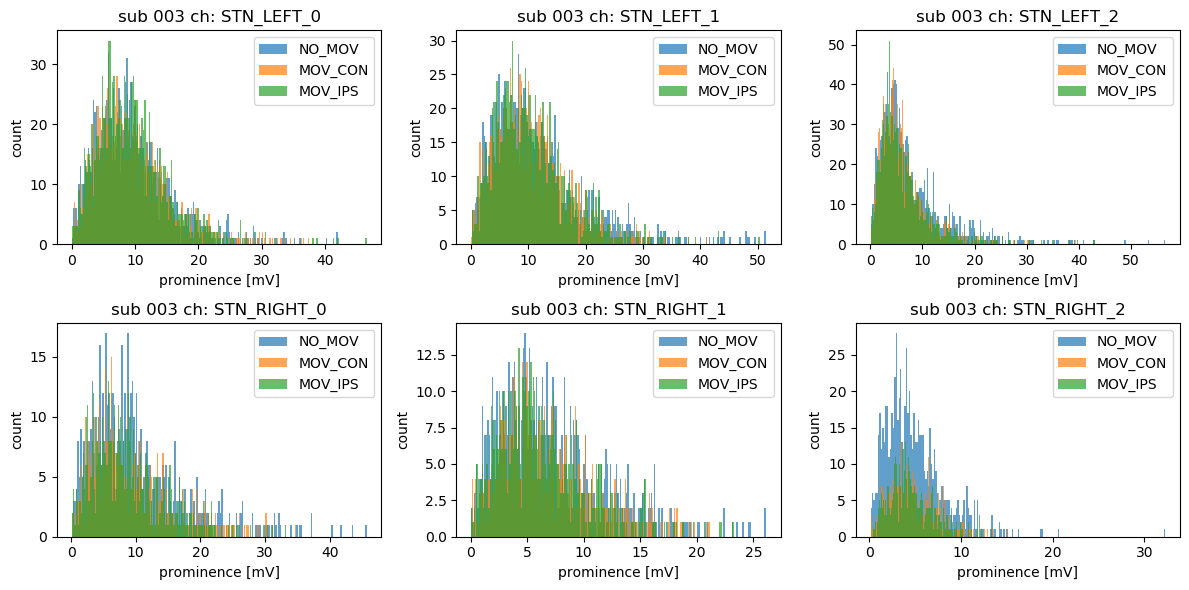

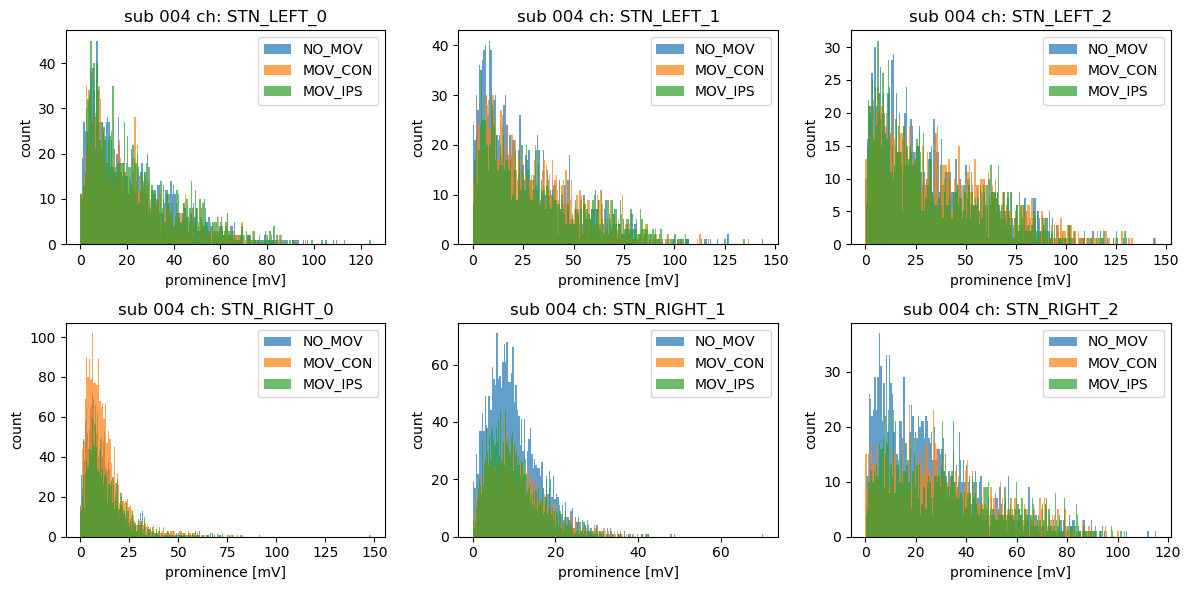

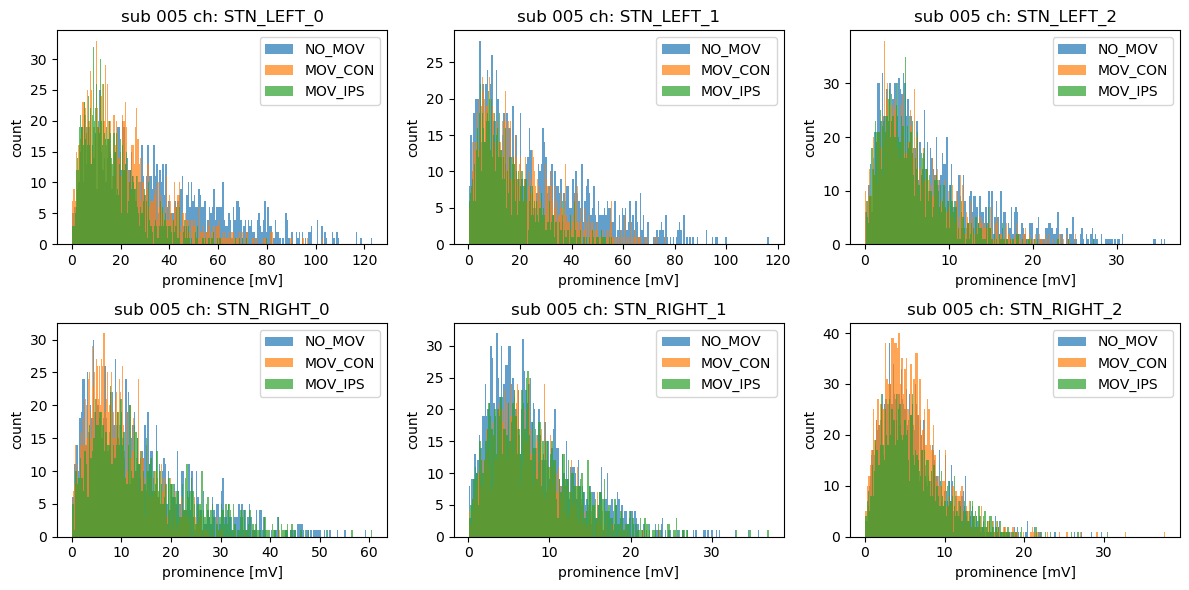

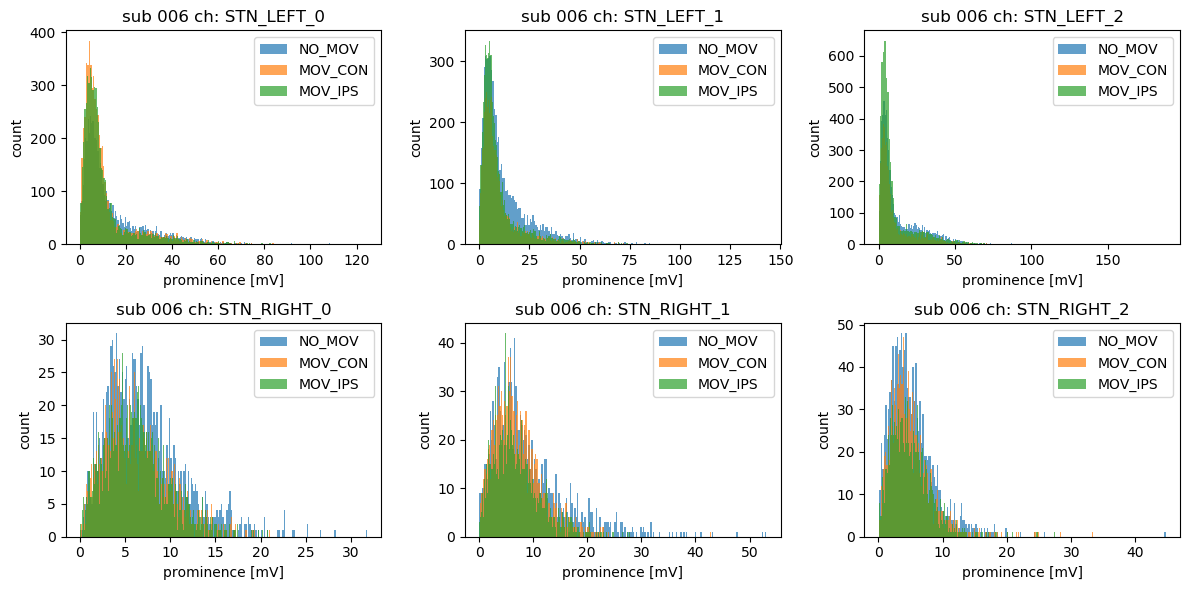

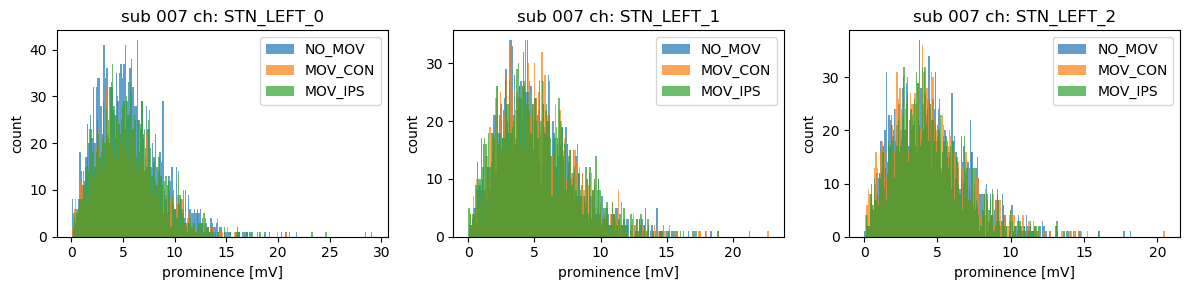

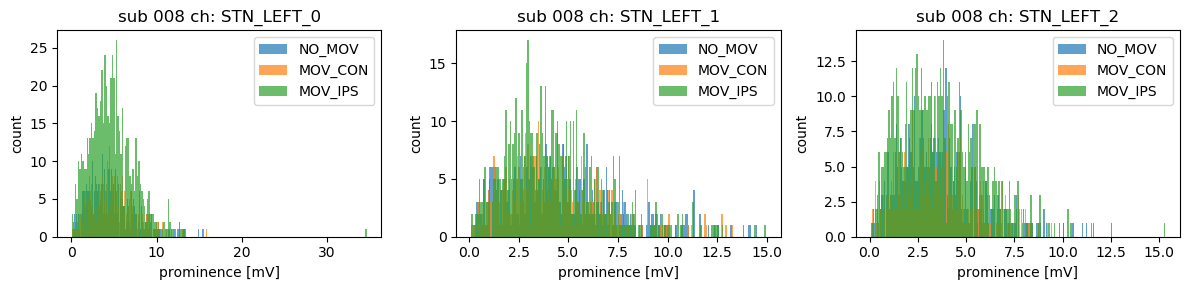

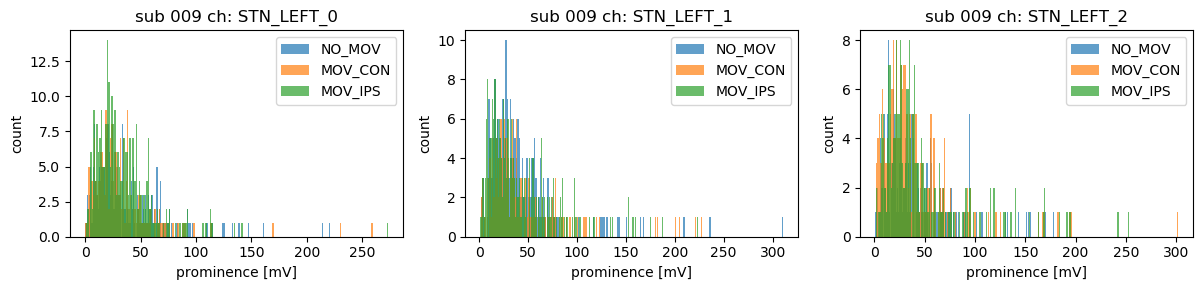

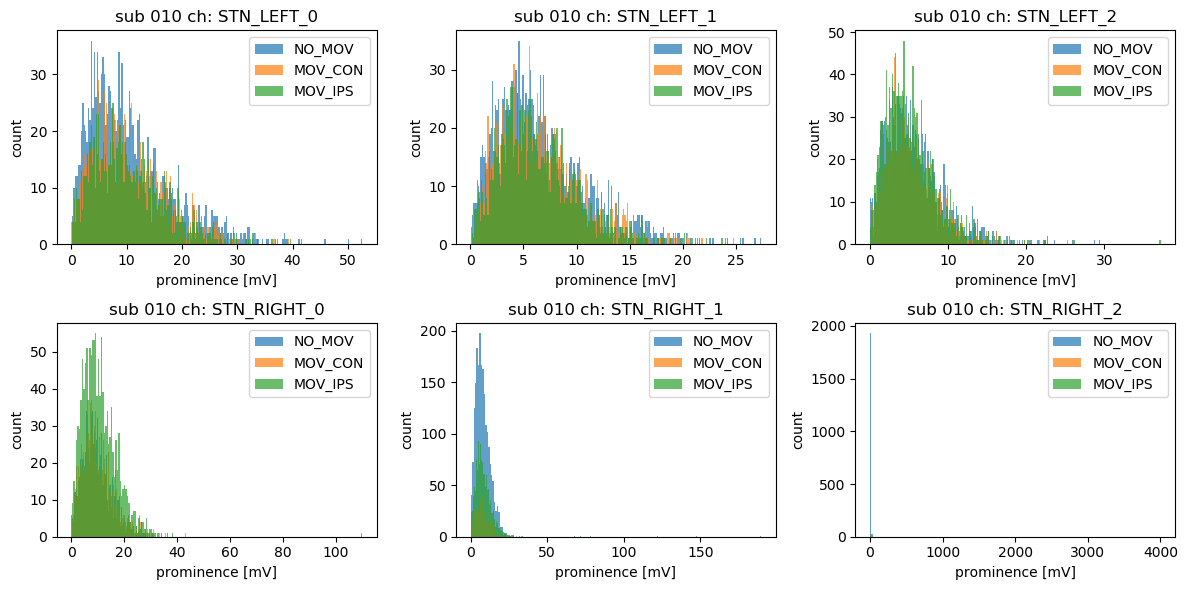

<Figure size 1200x0 with 0 Axes>

<Figure size 1200x0 with 0 Axes>

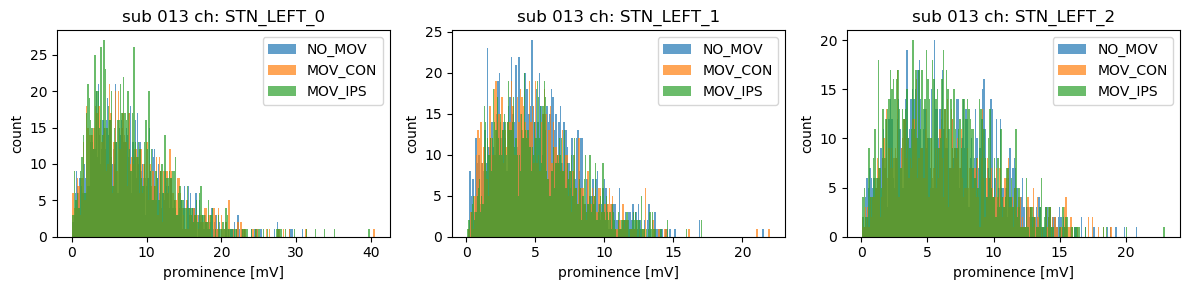

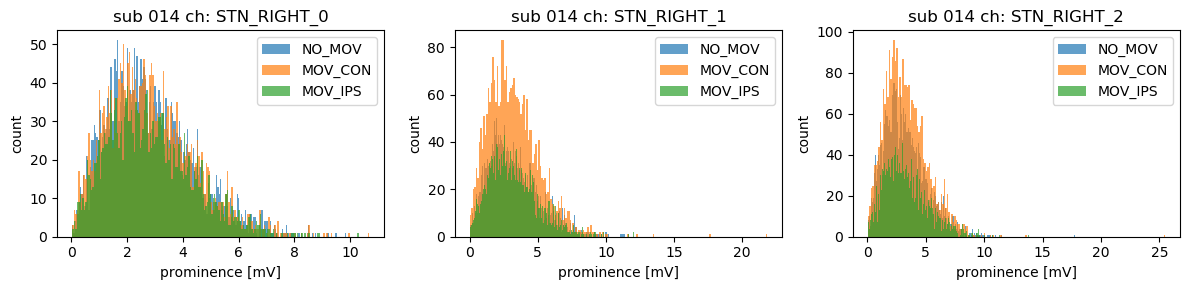

<Figure size 1200x0 with 0 Axes>

In [21]:
loc = "STN"
subjects = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']
for sub in subjects:
    res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
    files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))
    num_rows = np.ceil(files.shape[0]/3)
    plt.figure(figsize=(12,num_rows*3), dpi=100)
    for idx, f in enumerate(files):
        plt.subplot(num_rows,3,idx+1)
        ch_ = f[11:-2]
        downsample_factor = int(1/(np.where(res[ch_]["mov_con"]>0)[0].shape[0] / \
                            np.where((res[ch_]["mov_con"]==0) & (res[ch_]["mov_ips"]==0))[0].shape[0]))

        df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, f), allow_pickle=True)
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("NO_MOV")]["prominence"][::downsample_factor], 
                 bins=200, alpha=0.7, label="NO_MOV")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("CON")]["prominence"], bins=200, alpha=0.7, label="MOV_CON")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("IPS")]["prominence"], bins=200, alpha=0.7, label="MOV_IPS")
        plt.legend()
        plt.xlabel('prominence [mV]')
        plt.ylabel("count")
        plt.title("sub "+str(sub)+ " ch: "+ str(ch_))
    plt.tight_layout()
    plt.show()

#### For Sharp Waves with prominence > 50mV, what is the timing wrt movement onset; for a single channel? 

In [6]:
sub = "000"
loc = "ECOG"
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))

f = files[0] # channel
df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, f), allow_pickle=True) 

In [53]:
f

'sub_000_ch_ECOG_RIGHT_0.p'

In [54]:
ch_ = f[11:-2]

In [55]:
ch_

'ECOG_RIGHT_0'

In [7]:
# hier: movement con
def get_time_left_right(trough_ind, arr_ind_mov):
    #trough_ind = df_TROUGHS["trough_idx"][5000]
    #arr_ind_mov = np.where(res[ch_]["mov_con"]>0)[0]

    ind_greater = np.where(arr_ind_mov>trough_ind)[0]
    if ind_greater.shape[0] == 0:
        raise NoValidTroughException("No valid trough")
    val_ind_greater = arr_ind_mov[ind_greater]
    mov_right_idx = arr_ind_mov[ind_greater[np.argsort(val_ind_greater)[0]]]

    ind_smaller = np.where(arr_ind_mov<trough_ind)[0]
    if ind_smaller.shape[0] == 0:
        raise NoValidTroughException("No valid trough")

    val_ind_smaller = arr_ind_mov[ind_smaller]
    mov_left_idx = arr_ind_mov[ind_smaller[np.argsort(val_ind_smaller)[-1]]]
    
    return trough_ind-mov_left_idx, mov_right_idx-trough_ind

In [58]:
dist_con_left = []; dist_con_right = []
mov_ind = np.where(res[ch_]["mov_ips"]>0)[0]
for trough_idx in df_TROUGHS["trough_idx"]:
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_con_left.append(t_dist_left); dist_con_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue

dist_ips_left = []; dist_ips_right = []
mov_ind = np.where(res[ch_]["mov_con"]>0)[0]
for trough_idx in df_TROUGHS["trough_idx"]:
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_ips_left.append(t_dist_left); dist_ips_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue

Text(0.5, 0, 'Time [s]')

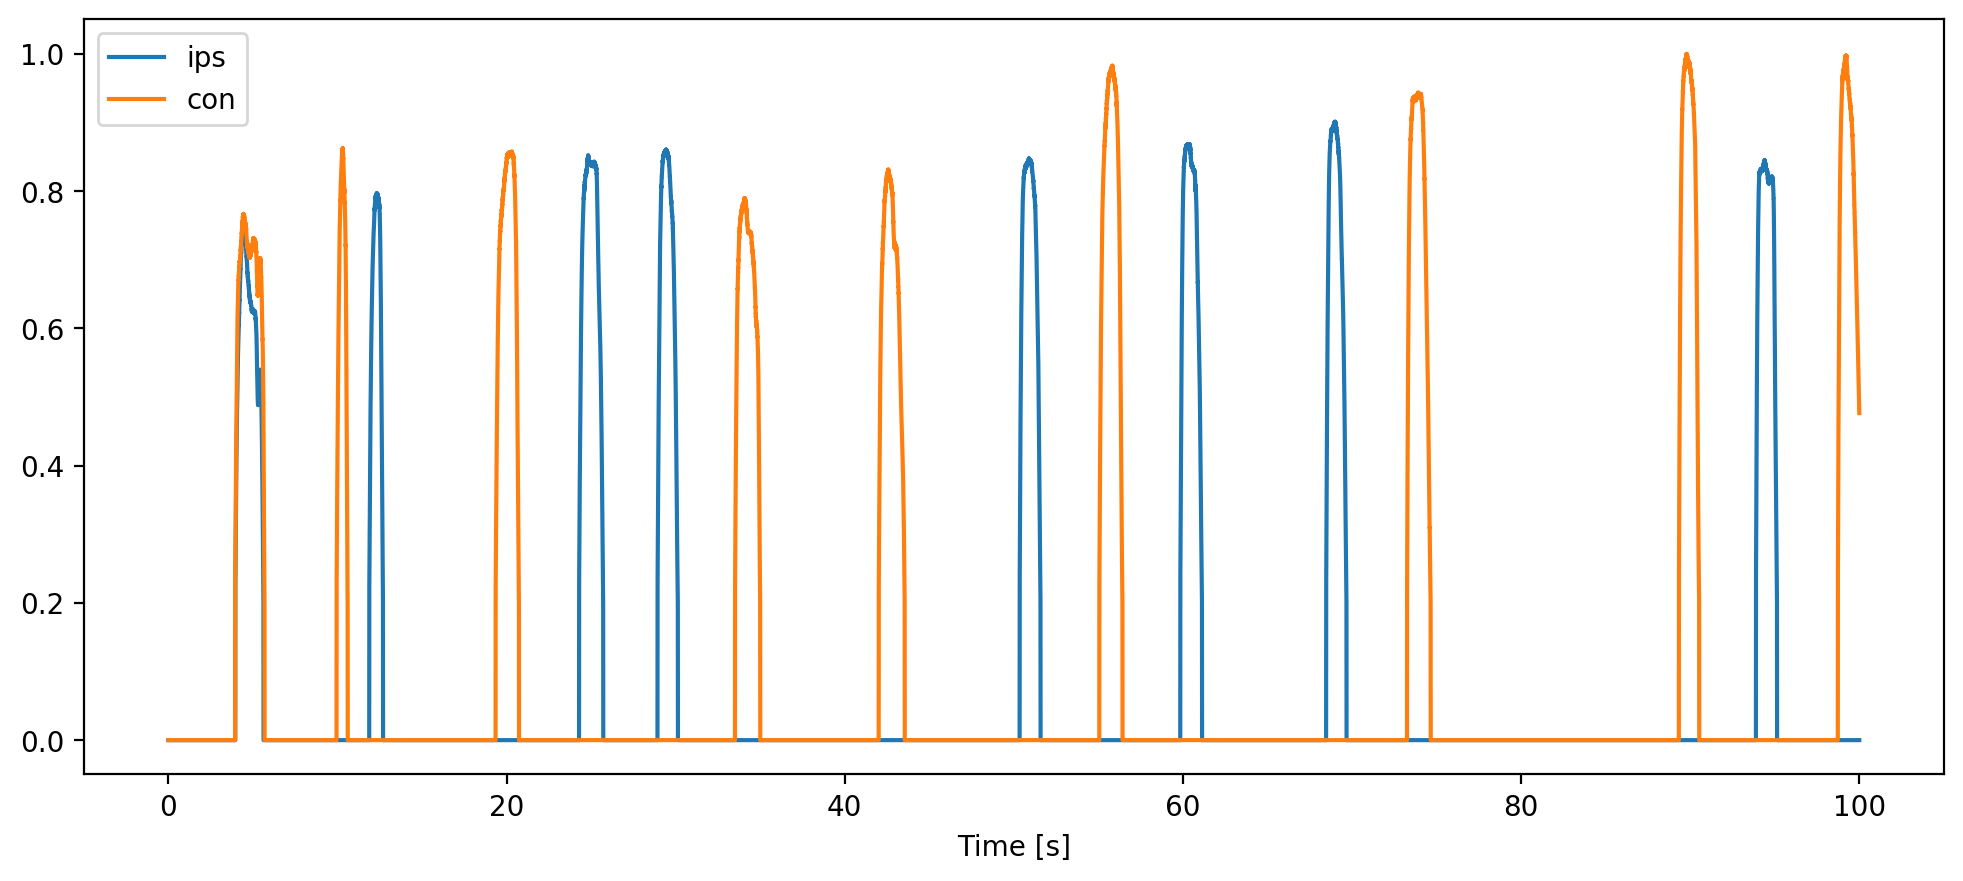

In [62]:
plt.figure(figsize=(12,5), dpi=200)
x_ = np.arange(0, res[ch_]["mov_ips"].shape[0], 1)/1000
plt.plot(x_[:100000], res[ch_]["mov_ips"][:100000], label="ips")
plt.plot(x_[:100000], res[ch_]["mov_con"][:100000], label="con")
plt.legend()
plt.xlabel("Time [s]")

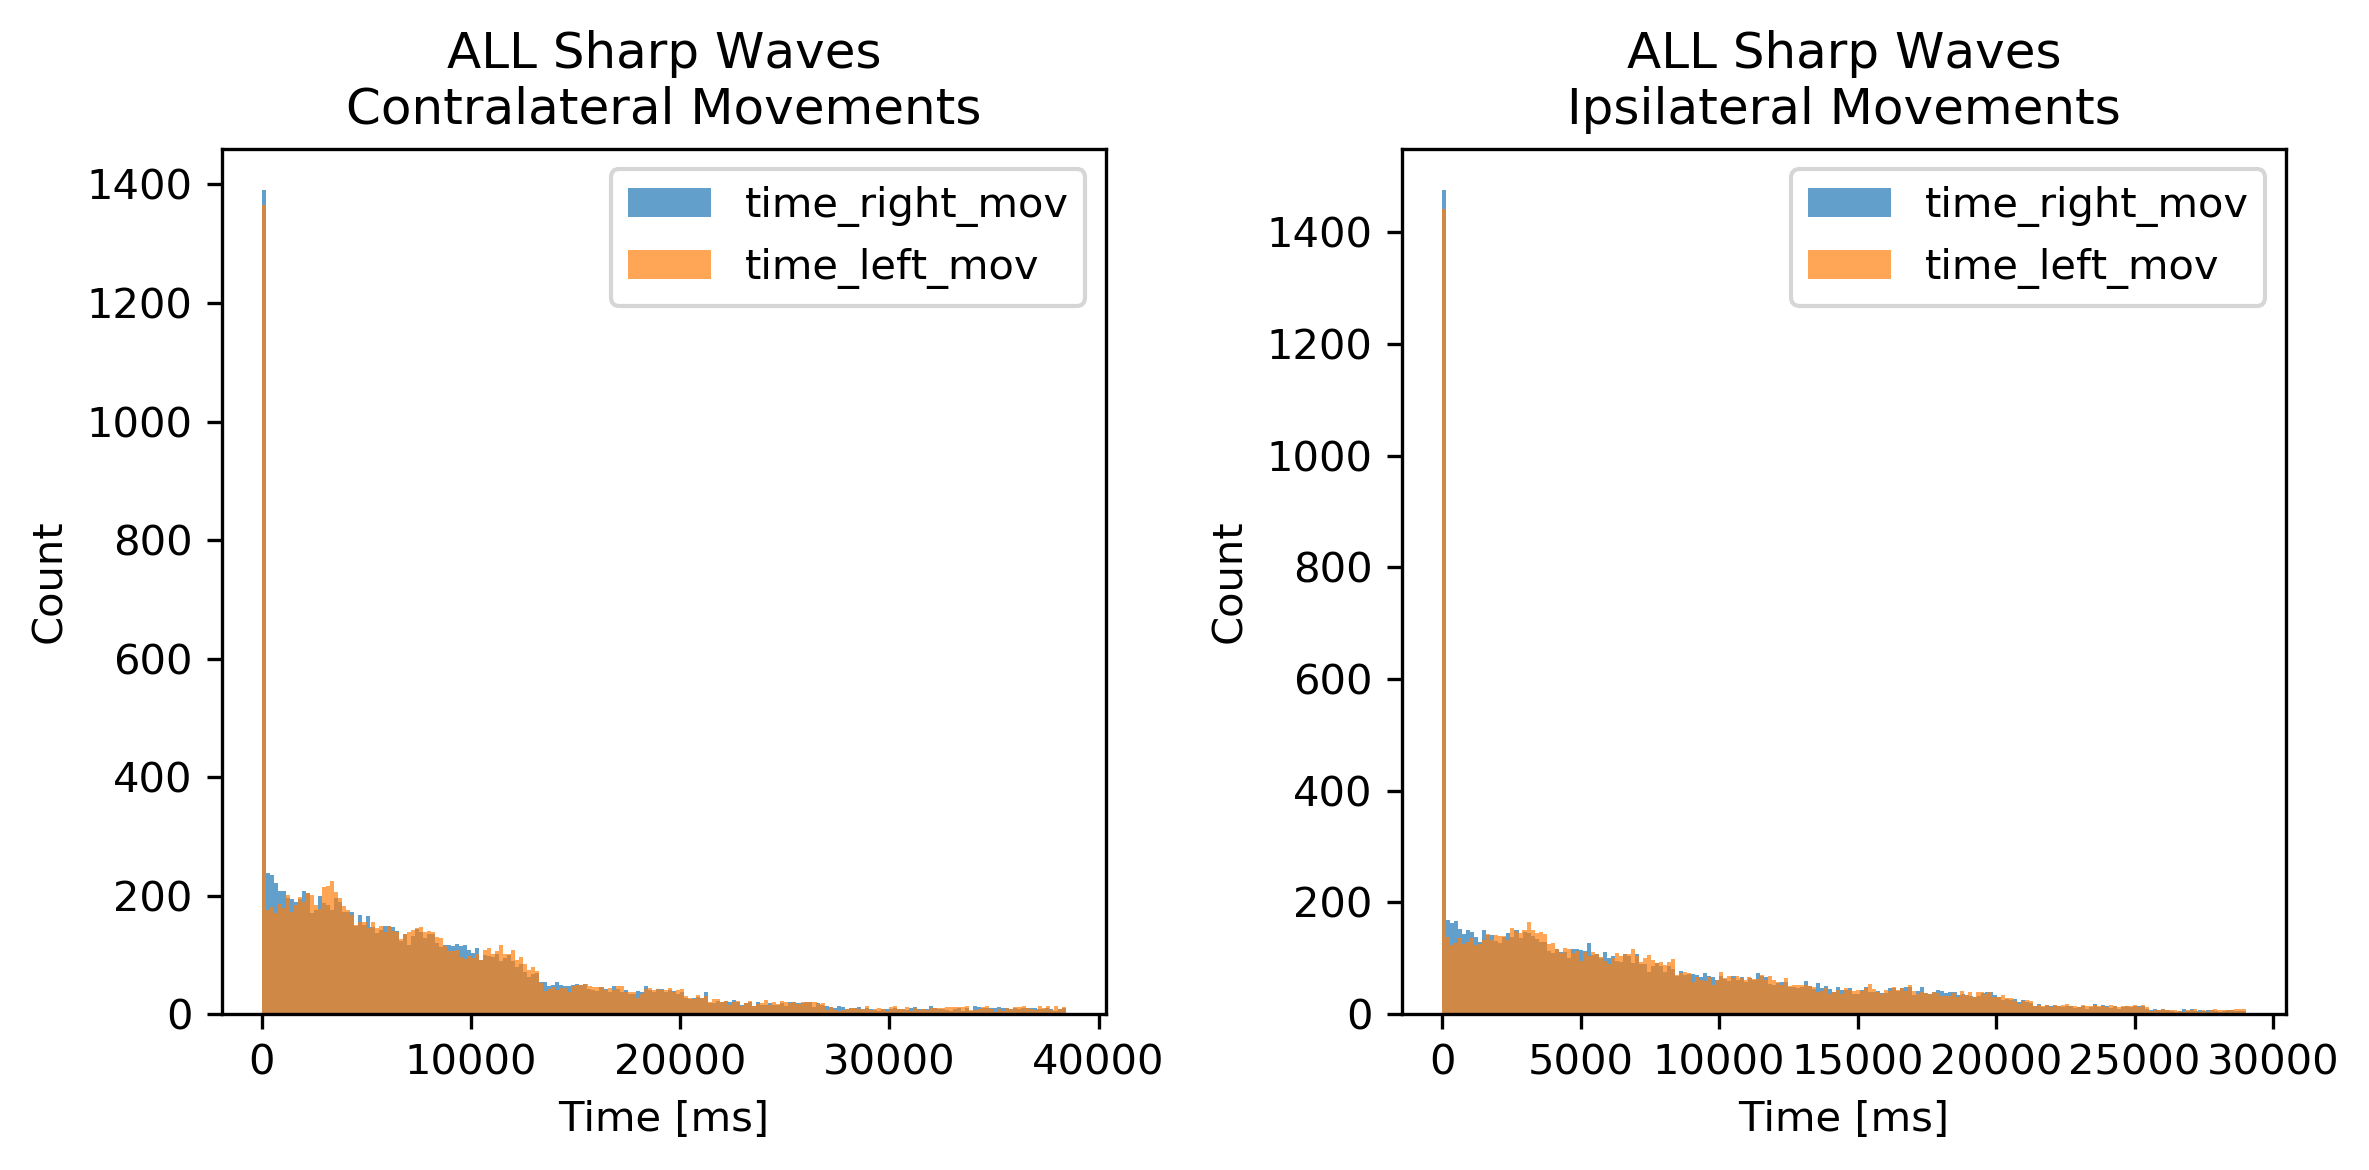

In [34]:
plt.figure(figsize=(8,4), dpi=300)
plt.subplot(121)
plt.hist(dist_con_right, alpha=0.7, bins=200, label="time_right_mov")
plt.hist(dist_con_left, alpha=0.7, bins=200, label="time_left_mov")
plt.title("ALL Sharp Waves\nContralateral Movements")
plt.xlabel('Time [ms]')
plt.ylabel("Count")
plt.legend()
plt.subplot(122)
plt.hist(dist_ips_right, alpha=0.7, bins=200, label="time_right_mov")
plt.hist(dist_ips_left, alpha=0.7, bins=200, label="time_left_mov")
plt.title("ALL Sharp Waves\nIpsilateral Movements")
plt.xlabel('Time [ms]')
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
dist_con_left = []; dist_con_right = []
mov_ind = np.where(res[ch_]["mov_ips"]>0)[0]
for idx_df, trough_idx in enumerate(df_TROUGHS["trough_idx"]):
    if df_TROUGHS.iloc[idx_df]["prominence"] < 100:
        continue
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_con_left.append(t_dist_left); dist_con_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue

dist_ips_left = []; dist_ips_right = []
mov_ind = np.where(res[ch_]["mov_con"]>0)[0]
for idx_df, trough_idx in enumerate(df_TROUGHS["trough_idx"]):
    if df_TROUGHS.iloc[idx_df]["prominence"] < 100:
        continue
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_ips_left.append(t_dist_left); dist_ips_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue

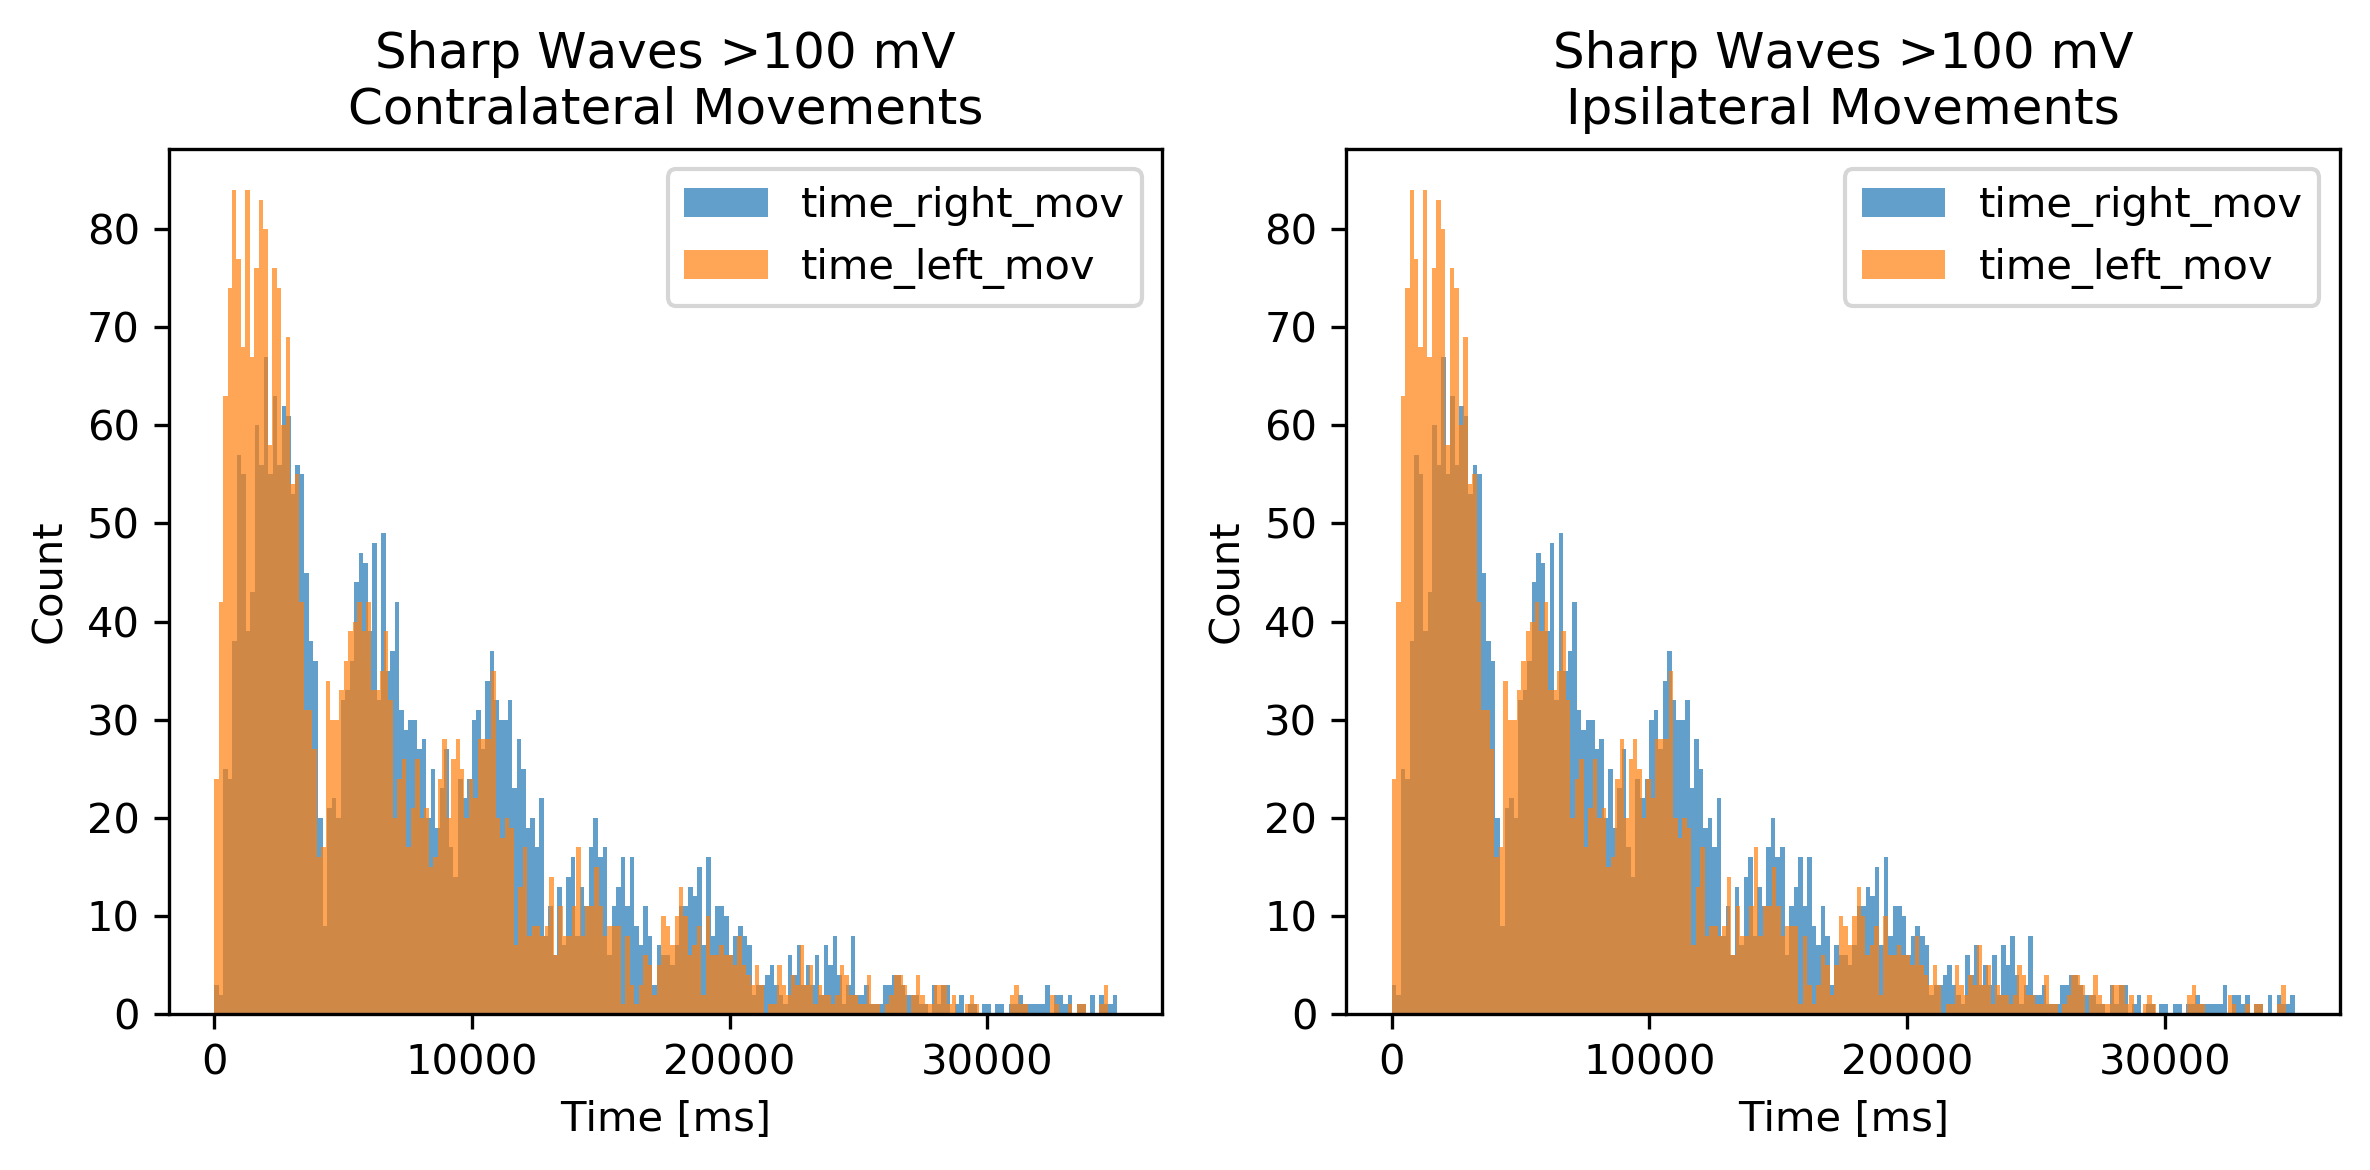

In [55]:
plt.figure(figsize=(8,4), dpi=300)
plt.subplot(121)
plt.hist(dist_con_right, alpha=0.7, bins=200, label="time_right_mov")
plt.hist(dist_con_left, alpha=0.7, bins=200, label="time_left_mov")
plt.title("Sharp Waves >100 mV\nContralateral Movements")
plt.xlabel('Time [ms]')
plt.legend()
plt.ylabel("Count")
plt.subplot(122)
plt.hist(dist_ips_right, alpha=0.7, bins=200, label="time_right_mov")
plt.hist(dist_ips_left, alpha=0.7, bins=200, label="time_left_mov")
plt.title("Sharp Waves >100 mV\nIpsilateral Movements")
plt.xlabel('Time [ms]')
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

#### Does the multinomial distribution come from contra and ipsilatera movements?

In [63]:
dist_all_left = []; dist_all_right = []
mov_ind = np.where((res[ch_]["mov_ips"]>0) | (res[ch_]["mov_con"]>0))[0]
for idx_df, trough_idx in enumerate(df_TROUGHS["trough_idx"]):
    if df_TROUGHS.iloc[idx_df]["prominence"] < 50:
        continue
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_all_left.append(t_dist_left); dist_all_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue


Text(0, 0.5, 'Count')

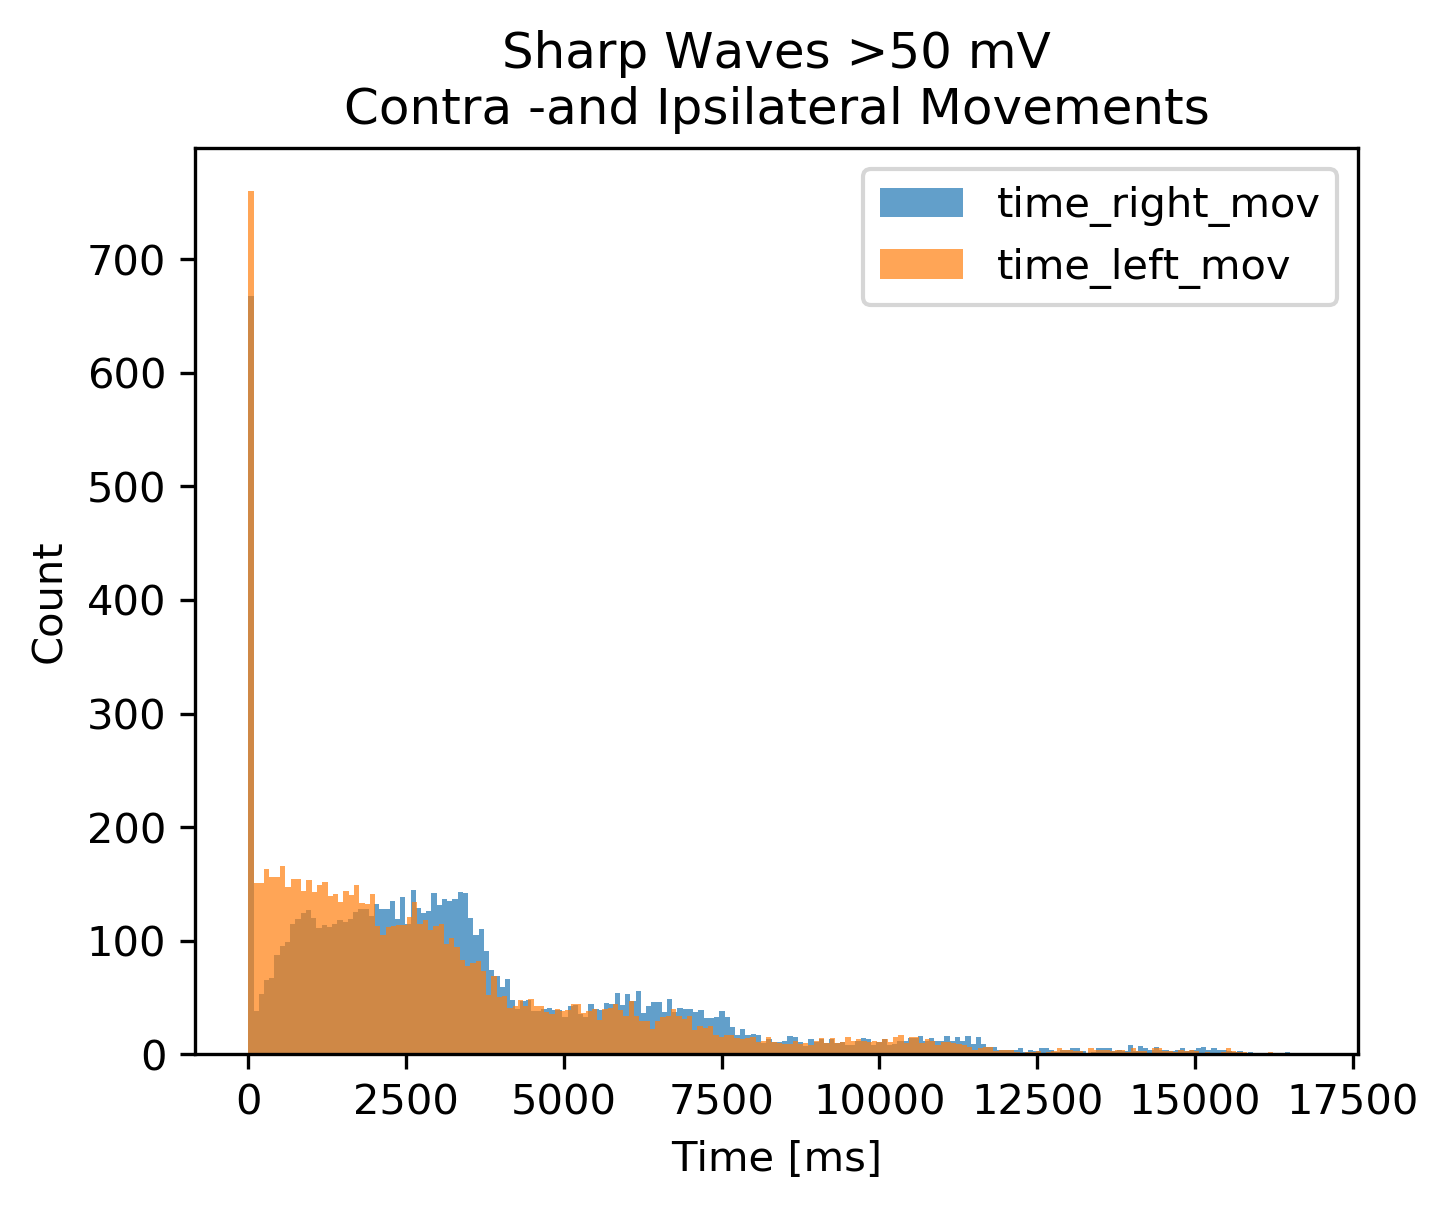

In [64]:
plt.figure(figsize=(5,4), dpi=300)
plt.hist(dist_all_right, alpha=0.7, bins=200, label="time_right_mov")
plt.hist(dist_all_left, alpha=0.7, bins=200, label="time_left_mov")
plt.title("Sharp Waves >50 mV\nContra -and Ipsilateral Movements")
plt.xlabel('Time [ms]')
#plt.xlim(0, 5000)
plt.legend()
plt.ylabel("Count")

#### Taking sum of con. and ips. and also downsample the distrbution s.t. the number of sharpwaves is same for mov / no mov

In [66]:
dist_all_left = []; dist_all_right = []
mov_ind = np.where((res[ch_]["mov_ips"]>0) | (res[ch_]["mov_con"]>0))[0]
for idx_df, trough_idx in enumerate(df_TROUGHS["trough_idx"]):
    if df_TROUGHS.iloc[idx_df]["prominence"] < 50:
        continue
    try:
        t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
        dist_all_left.append(t_dist_left); dist_all_right.append(t_dist_right); 
    except NoValidTroughException as e:
        continue


Text(0, 0.5, 'Count')

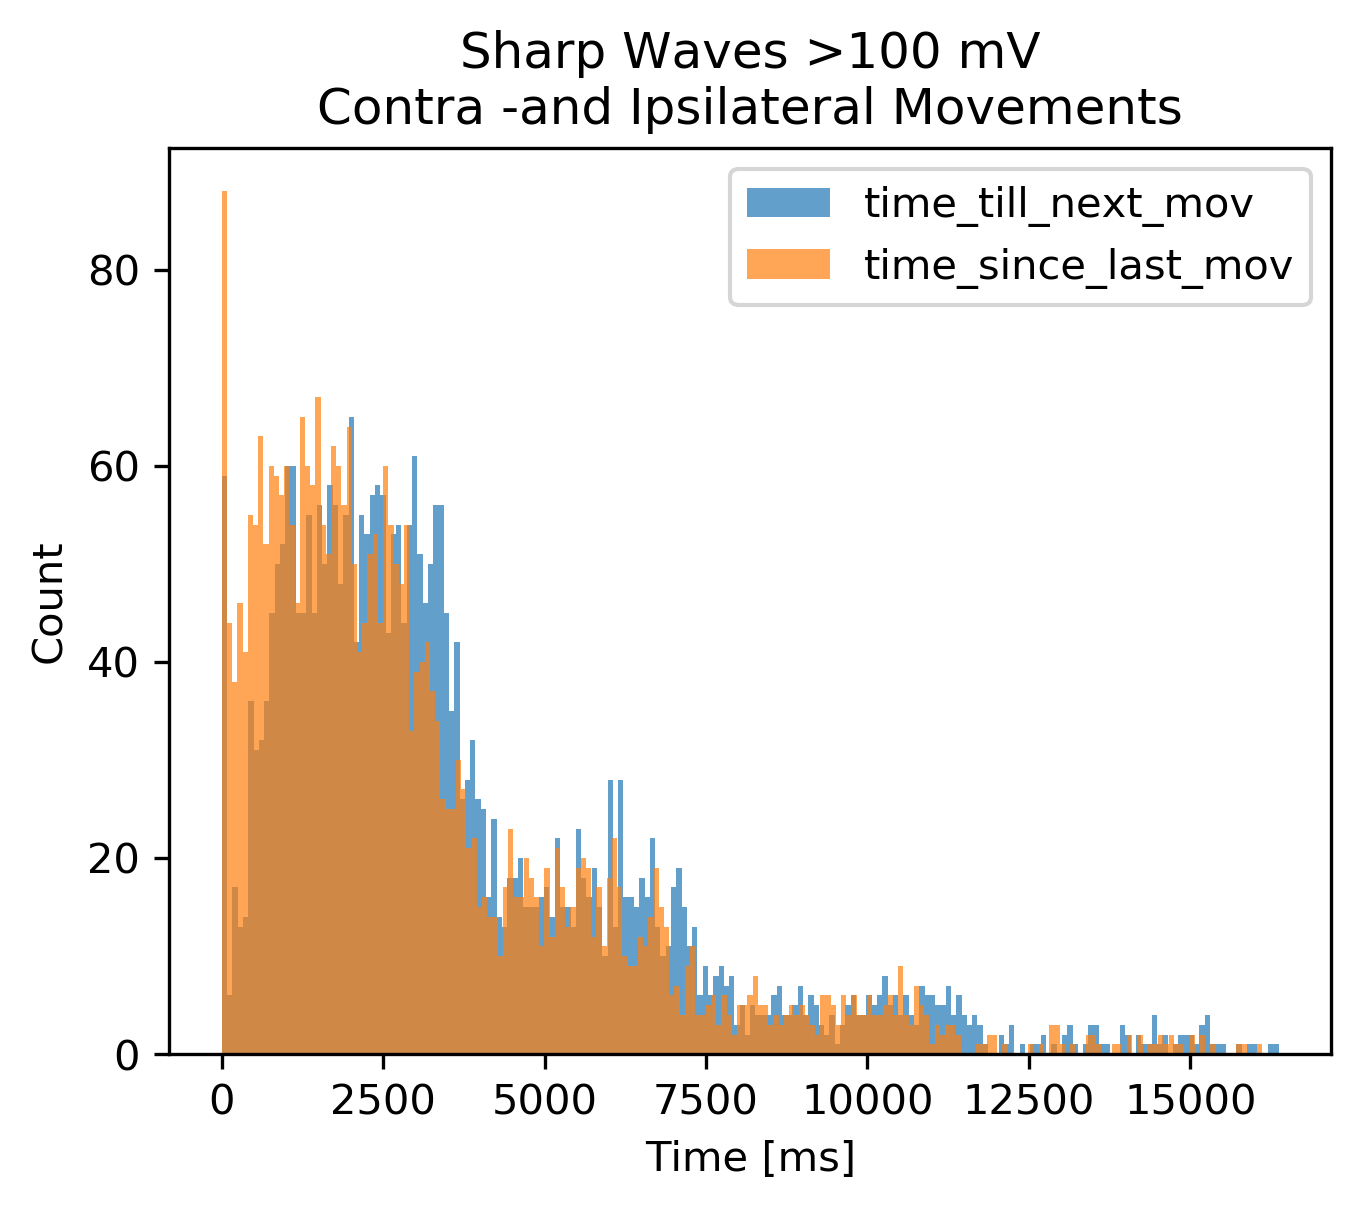

In [69]:
plt.figure(figsize=(5,4), dpi=300)
plt.hist(dist_all_right, alpha=0.7, bins=200, label="time_till_next_mov")
plt.hist(dist_all_left, alpha=0.7, bins=200, label="time_since_last_mov")
plt.title("Sharp Waves >100 mV\nContra -and Ipsilateral Movements")
plt.xlabel('Time [ms]')
#plt.xlim(0, 5000)
plt.legend()
plt.ylabel("Count")

### Run this analysis for every single channel

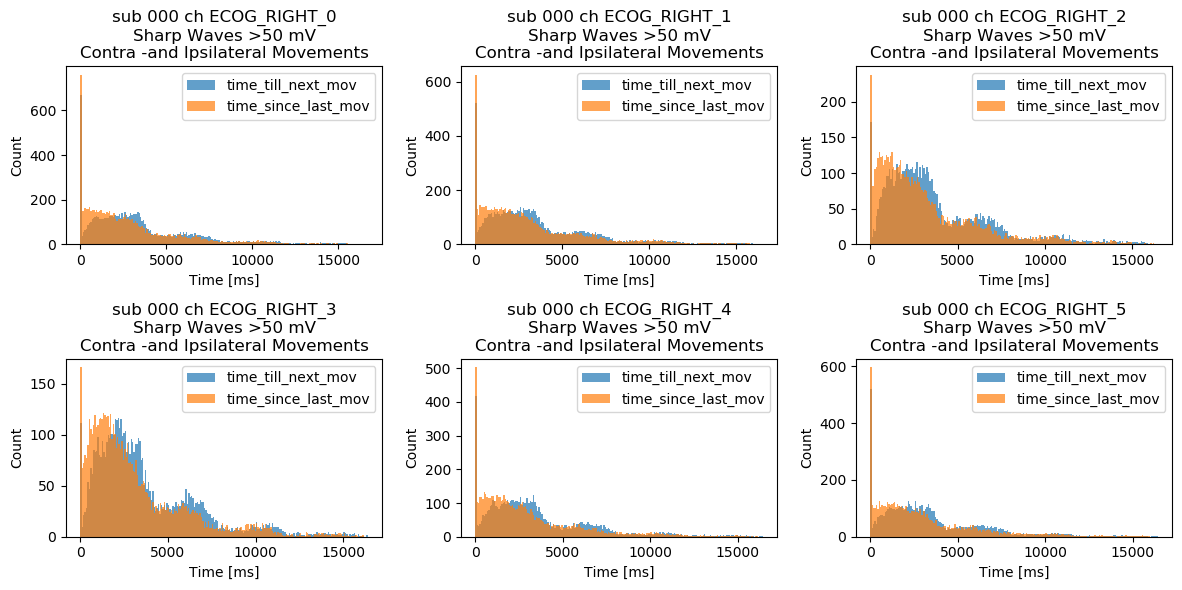

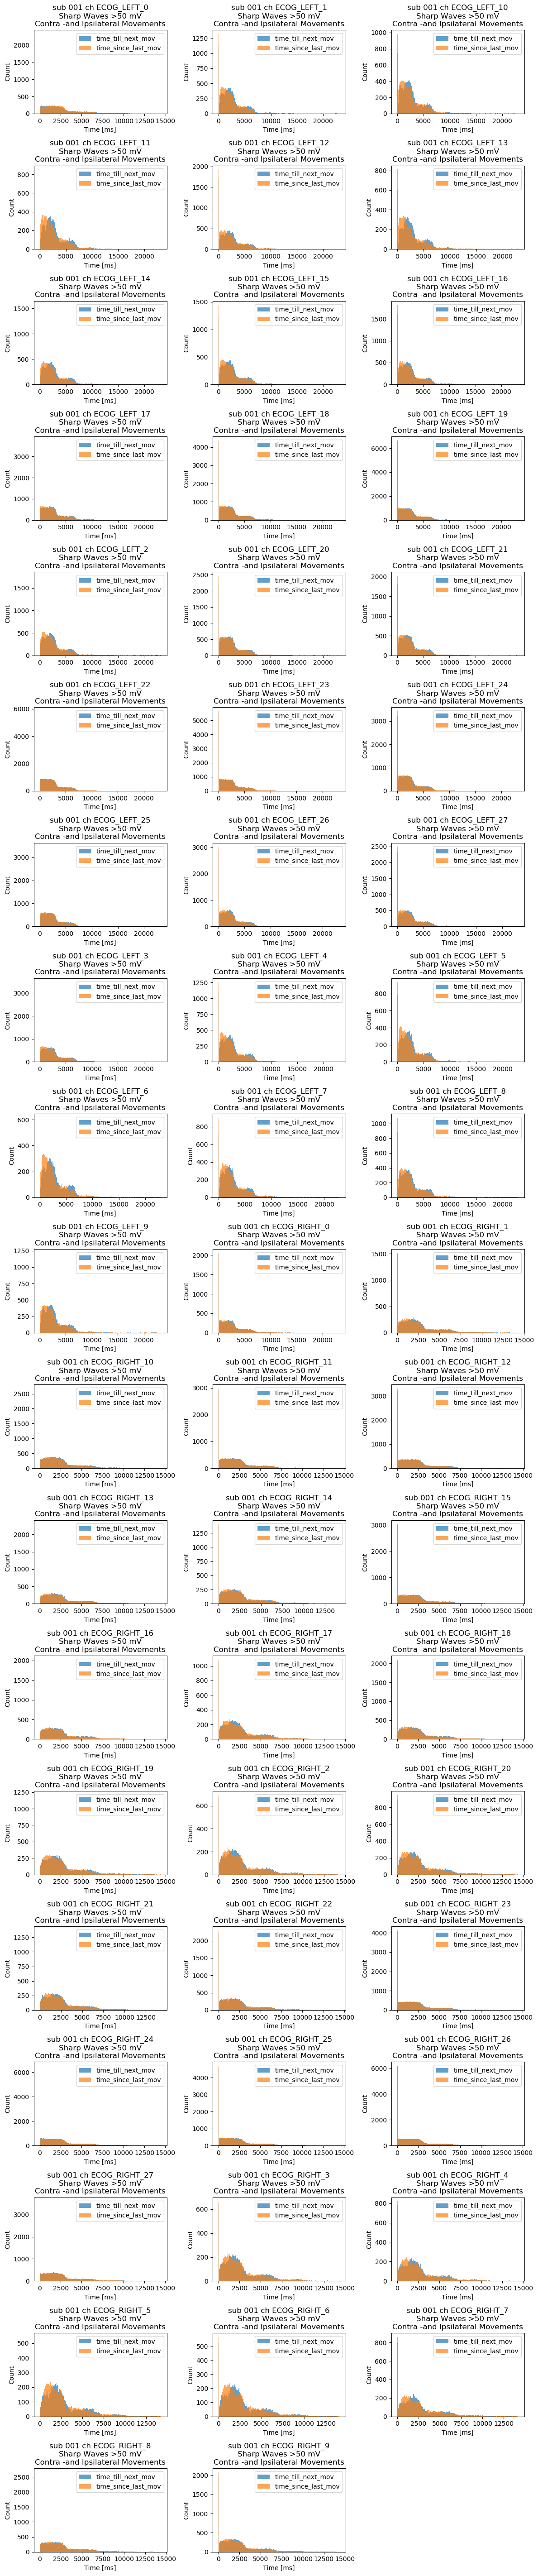

KeyError: 'ECOG_RIGHT_9'

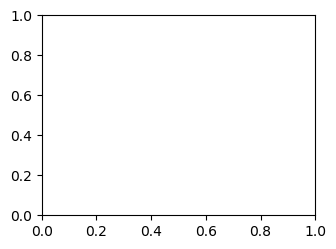

In [71]:
loc = "ECOG"
subjects = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']
for sub in subjects:
    res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
    files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))
    num_rows = np.ceil(files.shape[0]/3)
    plt.figure(figsize=(12,num_rows*3), dpi=100)
    for idx, f in enumerate(files):
        plt.subplot(num_rows,3,idx+1)
        dist_all_left = []; dist_all_right = []
        mov_ind = np.where((res[ch_]["mov_ips"]>0) | (res[ch_]["mov_con"]>0))[0]
        ch_ = f[11:-2]
        df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, f), allow_pickle=True) 
        
        for idx_df, trough_idx in enumerate(df_TROUGHS["trough_idx"]):
            if df_TROUGHS.iloc[idx_df]["prominence"] < 50:
                continue
            try:
                t_dist_left, t_dist_right = get_time_left_right(trough_idx, mov_ind)
                dist_all_left.append(t_dist_left); dist_all_right.append(t_dist_right); 
            except NoValidTroughException as e:
                continue

        plt.hist(dist_all_right, alpha=0.7, bins=200, label="time_till_next_mov")
        plt.hist(dist_all_left, alpha=0.7, bins=200, label="time_since_last_mov")
        plt.title("sub "+str(sub)+" ch "+str(ch_)+"\nSharp Waves >50 mV\nContra -and Ipsilateral Movements")
        plt.xlabel('Time [ms]')
        #plt.xlim(0, 5000)
        plt.legend()
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Analyze performance based on prominence

In [6]:
subjects = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']

In [8]:
for sub in subjects:
    res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
    files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))
    num_rows = np.ceil(files.shape[0]/3)
    plt.figure(figsize=(12,num_rows*3), dpi=100)
    for idx, f in enumerate(files):
        plt.subplot(num_rows,3,idx+1)
        ch_ = f[11:-2]
        downsample_factor = int(1/(np.where(res[ch_]["mov_con"]>0)[0].shape[0] / \
                            np.where((res[ch_]["mov_con"]==0) & (res[ch_]["mov_ips"]==0))[0].shape[0]))

        df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, f), allow_pickle=True)
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("NO_MOV")]["prominence"][::downsample_factor], 
                 bins=200, alpha=0.7, label="NO_MOV")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("CON")]["prominence"], bins=200, alpha=0.7, label="MOV_CON")
        plt.hist(df_TROUGHS[df_TROUGHS["MOV_TYPE"].str.contains("IPS")]["prominence"], bins=200, alpha=0.7, label="MOV_IPS")
        plt.legend()
        plt.xlabel('prominence [mV]')
        plt.ylabel("count")
        plt.title("sub "+str(sub)+ " ch: "+ str(ch_))
    plt.tight_layout()
    plt.show()

NameError: name 'subjects' is not defined

In [ ]:
# mhhh, for every patient & channel calculate rates of accuracies 
# so you need to get somehow the movement trace 
# real time movement decoding (look backwards 1s)
# how many sharpwaves - which prominence? 
# first read data from one channel 
# and analyte 1. AUC 2. F1 score 

In [8]:
sub = subjects[0]
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))

In [9]:
files

array(['sub_000_ch_ECOG_RIGHT_0.p', 'sub_000_ch_ECOG_RIGHT_1.p',
       'sub_000_ch_ECOG_RIGHT_2.p', 'sub_000_ch_ECOG_RIGHT_3.p',
       'sub_000_ch_ECOG_RIGHT_4.p', 'sub_000_ch_ECOG_RIGHT_5.p'],
      dtype='<U25')

In [10]:
df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, files[0]), allow_pickle=True)

In [ ]:
# mhhh, run through movement data in bins of 1s 

In [11]:
PATH_COMBINED

'C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\Combined_runs\\'

In [12]:
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)

In [26]:
label = res["ECOG_RIGHT_0"]["mov_con"][::100] # non downsampled: 1kHz --> 10HZ

In [ ]:
# data can be downsampled to 10 Hz

In [141]:
list(res.keys())

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'STN_RIGHT_0',
 'STN_RIGHT_1',
 'STN_RIGHT_2']

In [9]:
import multiprocessing

In [13]:
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)

In [11]:
pool = multiprocessing.Pool()

In [ ]:
pool.starmap(get_AUC_SW_pr, list(res.keys()))

In [12]:
def get_AUC_SW_pr(key):
    
    res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
    label = res[key]["mov_con"][::100] # non downsampled: 1kHz --> 10HZ
    pr_ = []
    for thr in np.arange(0, 150, 5):
        label_pr = np.ones((label.shape[0]), dtype=bool)
        print(thr)

        for t, f in enumerate(label): # t is hier in 10 Hz
            if t < 10:
                continue
            # I wanna check if there are any troughs in the last seconds? 
            prominences = df_TROUGHS[(df_TROUGHS["trough_idx"] < (t*100)) & 
                       (df_TROUGHS["trough_idx"] > (t-10)*100)]["prominence"]
            passed = True
            for p in prominences:
                if np.abs(p) > thr: 
                    passed = False
                    break
            label_pr[t] = passed
        pr_.append(label_pr)
    np.save(key+'_pr.npy', np.array(pr_))

In [137]:
np.save?

In [16]:
from sklearn import metrics

In [125]:
AUC_ = []
F1_ = []
for pr in pr_:
    AUC_.append(metrics.roc_auc_score(pr, label>0))
    F1_.append(metrics.f1_score(pr, label>0))

Text(0, 0.5, 'AUC/F1')

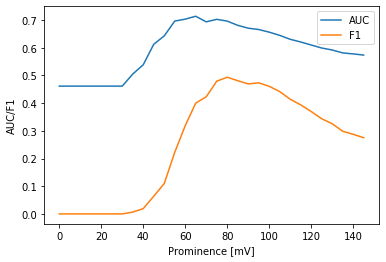

In [131]:
plt.plot(np.arange(0, 150, 5), AUC_, label='AUC')
plt.plot(np.arange(0, 150, 5), F1_, label='F1')
plt.legend()
plt.xlabel('Prominence [mV]')
plt.ylabel("AUC/F1")

In [12]:
sub = subjects[0]
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][0]), allow_pickle=True)
files = np.sort(np.array([f for f in files_peaks if loc in f and sub in f]))
df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, files[0]), allow_pickle=True)


In [13]:
# F1 seems to be highest at 0.8 
# now differ the timing fo max. F1 
key= "ECOG_RIGHT_0"
label = res[key]["mov_con"][::100] # non downsampled: 1kHz --> 10HZ
pr_t = []
thr = 80
for time_window in np.arange(0, 15, 1):
    label_pr = np.ones((label.shape[0]), dtype=bool)
    print(time_window)

    for t, f in enumerate(label): # t is hier in 10 Hz
        if t < 10:
            continue
        # I wanna check if there are any troughs in the last seconds? 
        prominences = df_TROUGHS[(df_TROUGHS["trough_idx"] < (t*100)) & 
                   (df_TROUGHS["trough_idx"] > (t-time_window)*100)]["prominence"]
        passed = True
        for p in prominences:
            if np.abs(p) > thr: 
                passed = False
                break
        label_pr[t] = passed
    pr_t.append(label_pr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [19]:
AUC_t = []
F1_t = []
for pr in pr_t:
    try:
        AUC_t.append(metrics.roc_auc_score(pr, label>0))
    except:
        AUC_t.append(0.5)
    F1_t.append(metrics.f1_score(pr, label>0))

Text(0, 0.5, 'AUC/F1')

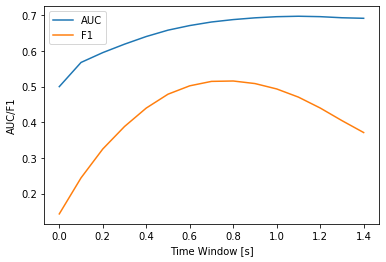

In [21]:
plt.plot(np.arange(0, 15, 1)/10, AUC_t, label='AUC')
plt.plot(np.arange(0, 15, 1)/10, F1_t, label='F1')
plt.legend()
plt.xlabel('Time Window [s]')
plt.ylabel("AUC/F1")

### find different comp. way

In [77]:
# F1 seems to be highest at 0.8 
# now differ the timing fo max. F1 
key= "ECOG_RIGHT_0"
label = res[key]["mov_con"][::100] # non downsampled: 1kHz --> 10HZ
thr_space = np.arange(0, 200, 10)
time_window_space = np.arange(0, 50, 1)
pr_array = np.ones((thr_space.shape[0],time_window_space.shape[0], label.shape[0]), dtype=bool)

for thr_idx, thr in enumerate(thr_space):
    print("threshold: "+str(thr))
    prominences_thr = np.zeros(label.shape[0], dtype=bool)
    # here a vector is creates of fs = 10Hz which determines presence of passed thr prominence
    t_arr = np.arange(0, label.shape[0], 1)*100
    for t_idx, t in enumerate(t_arr):
        if np.sum(df_TROUGHS[(df_TROUGHS["trough_idx"] < t) & 
                       (df_TROUGHS["trough_idx"] > (t-100))]["prominence"] > thr) > 0:
            prominences_thr[t_idx] = True

    t_arr = np.arange(time_window_space[-1], prominences_thr.shape[0], 1)
    for t_w_idx, time_window in enumerate(time_window_space):
        print(time_window)
        for t in t_arr: # t is hier in 10 Hz
            pr_array[thr_idx, t_w_idx, t] = False if np.sum(prominences_thr[t-time_window:t]) > 0 else True 


threshold: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 40
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
threshold: 60
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2

In [149]:
F1_t = np.zeros([thr_space.shape[0], time_window_space.shape[0]])
AUC_t = np.zeros([thr_space.shape[0], time_window_space.shape[0]])
for thr_i,_ in enumerate(thr_space):
    for tw_i,_ in enumerate(time_window_space):
        F1_t[thr_i, tw_i] = metrics.f1_score(pr_array[thr_i, tw_i,:], 
                            (res[key]["mov_con"][::100]+res[key]["mov_ips"][::100])>0)
        try:
            AUC_t[thr_i, tw_i] = metrics.roc_auc_score(pr_array[thr_i, tw_i,:], 
                            (res[key]["mov_con"][::100]+res[key]["mov_ips"][::100])>0) 
        except:
            AUC_t[thr_i, tw_i] = 0.5

Text(0.5, 1.0, 'AUC score hyperparameter search')

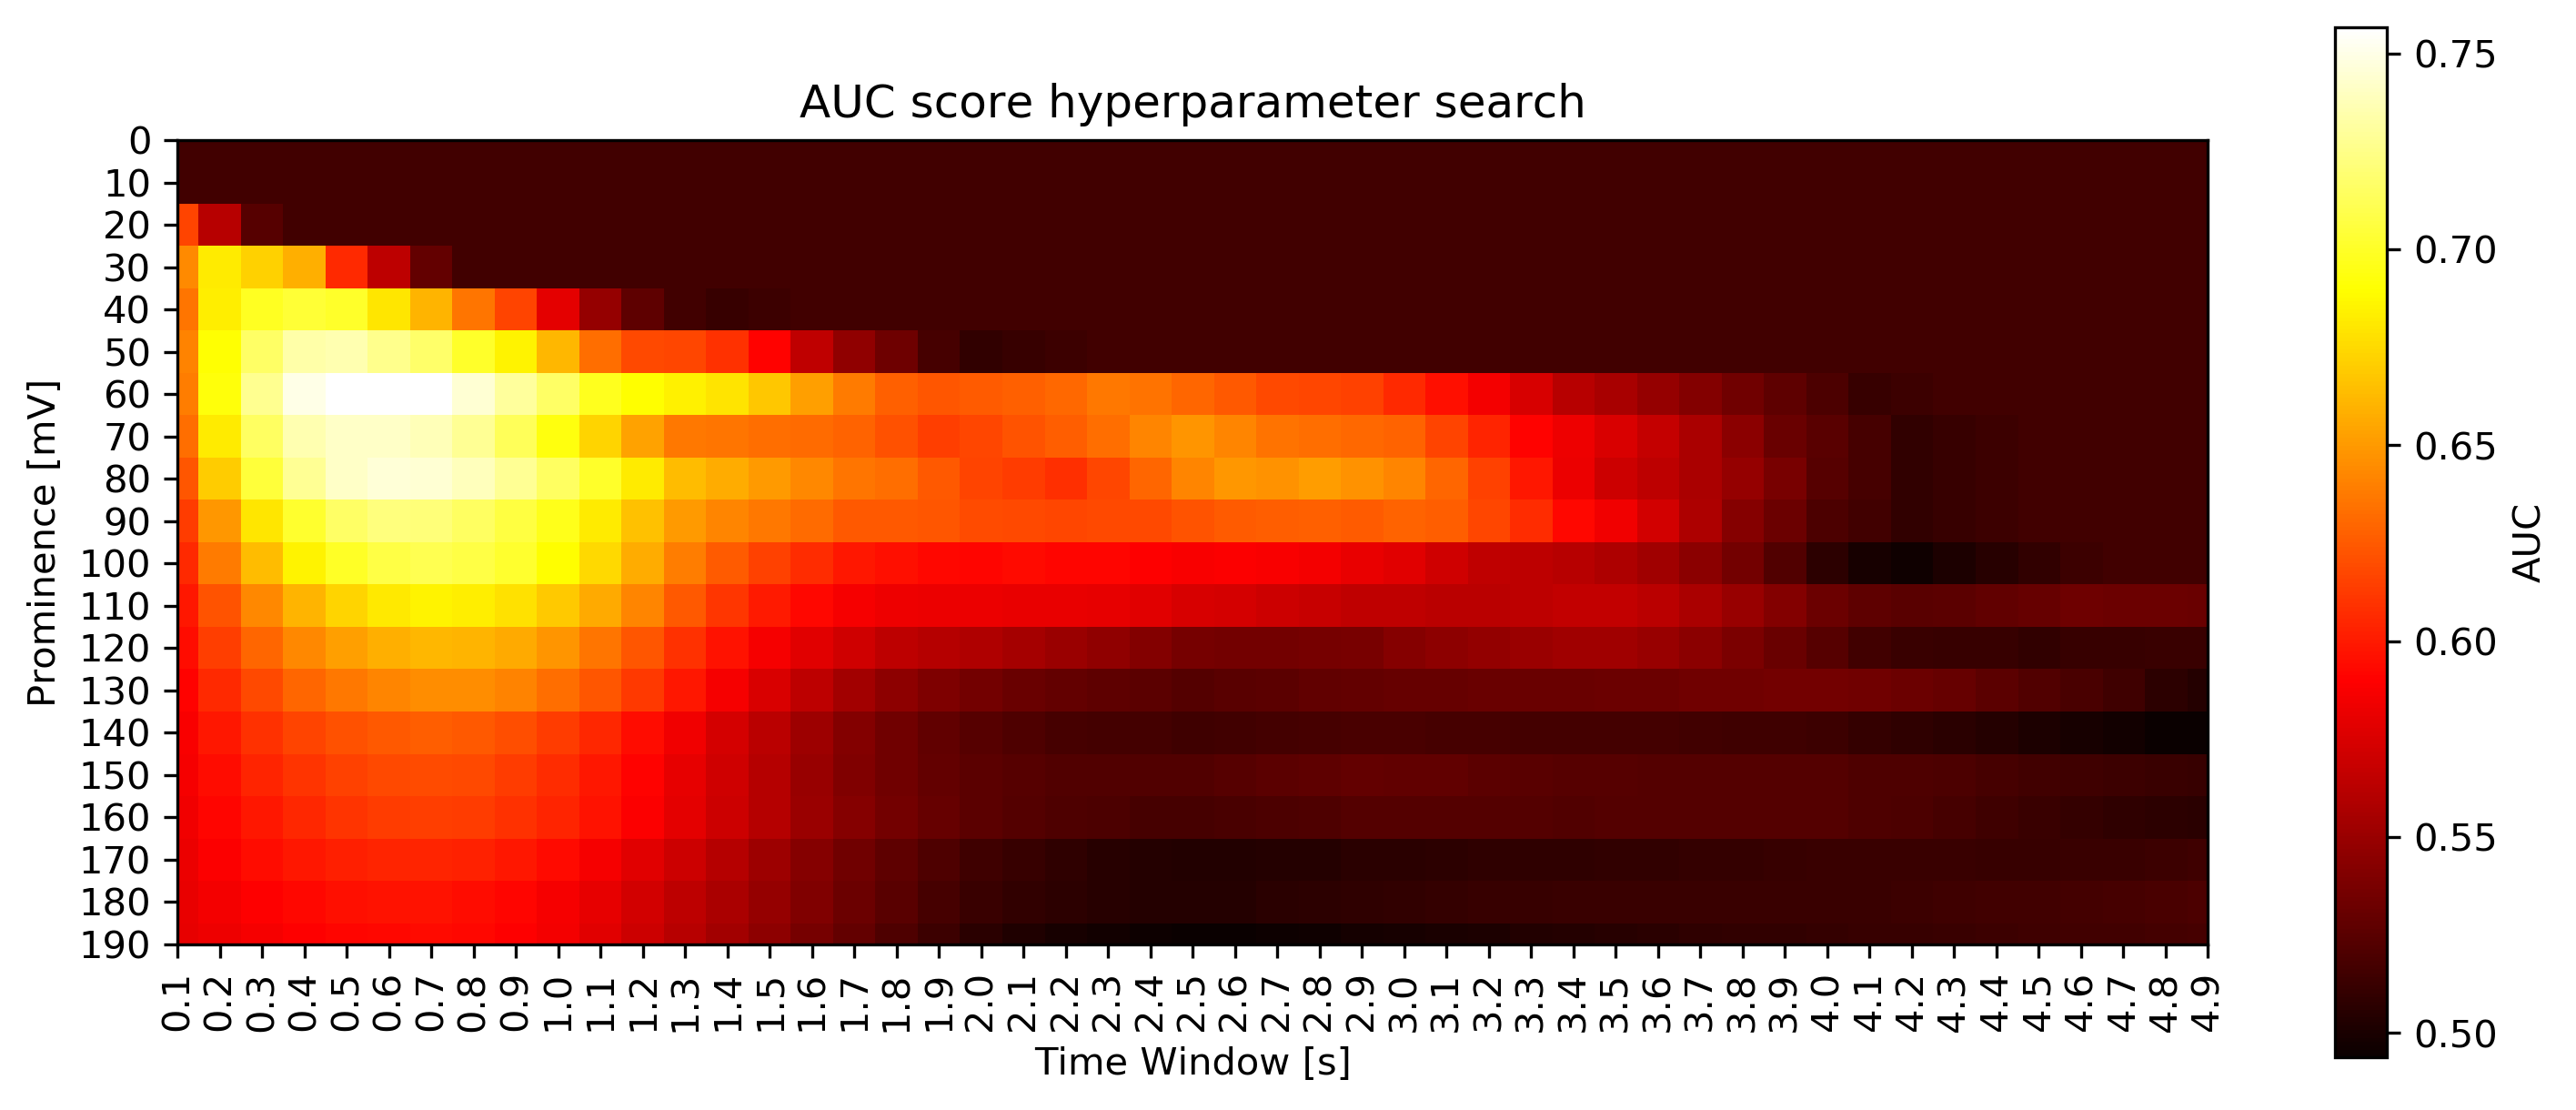

In [150]:
plt.figure(figsize=(12,5), dpi=300)
plt.imshow(AUC_t, cmap='hot')
plt.ylabel("Prominence [mV]"); plt.xlabel("Time Window [s]")
plt.yticks(range(thr_space.shape[0]),thr_space)
plt.xticks(range(int(time_window_space.shape[0]/1)),np.round(time_window_space[::1]/10,1), rotation=90)
plt.xlim(1,time_window_space.shape[0]-1)
cb = plt.colorbar()
cb.set_label("AUC")
plt.title("AUC score hyperparameter search")

Text(0.5, 1.0, 'F1 score hyperparameter search')

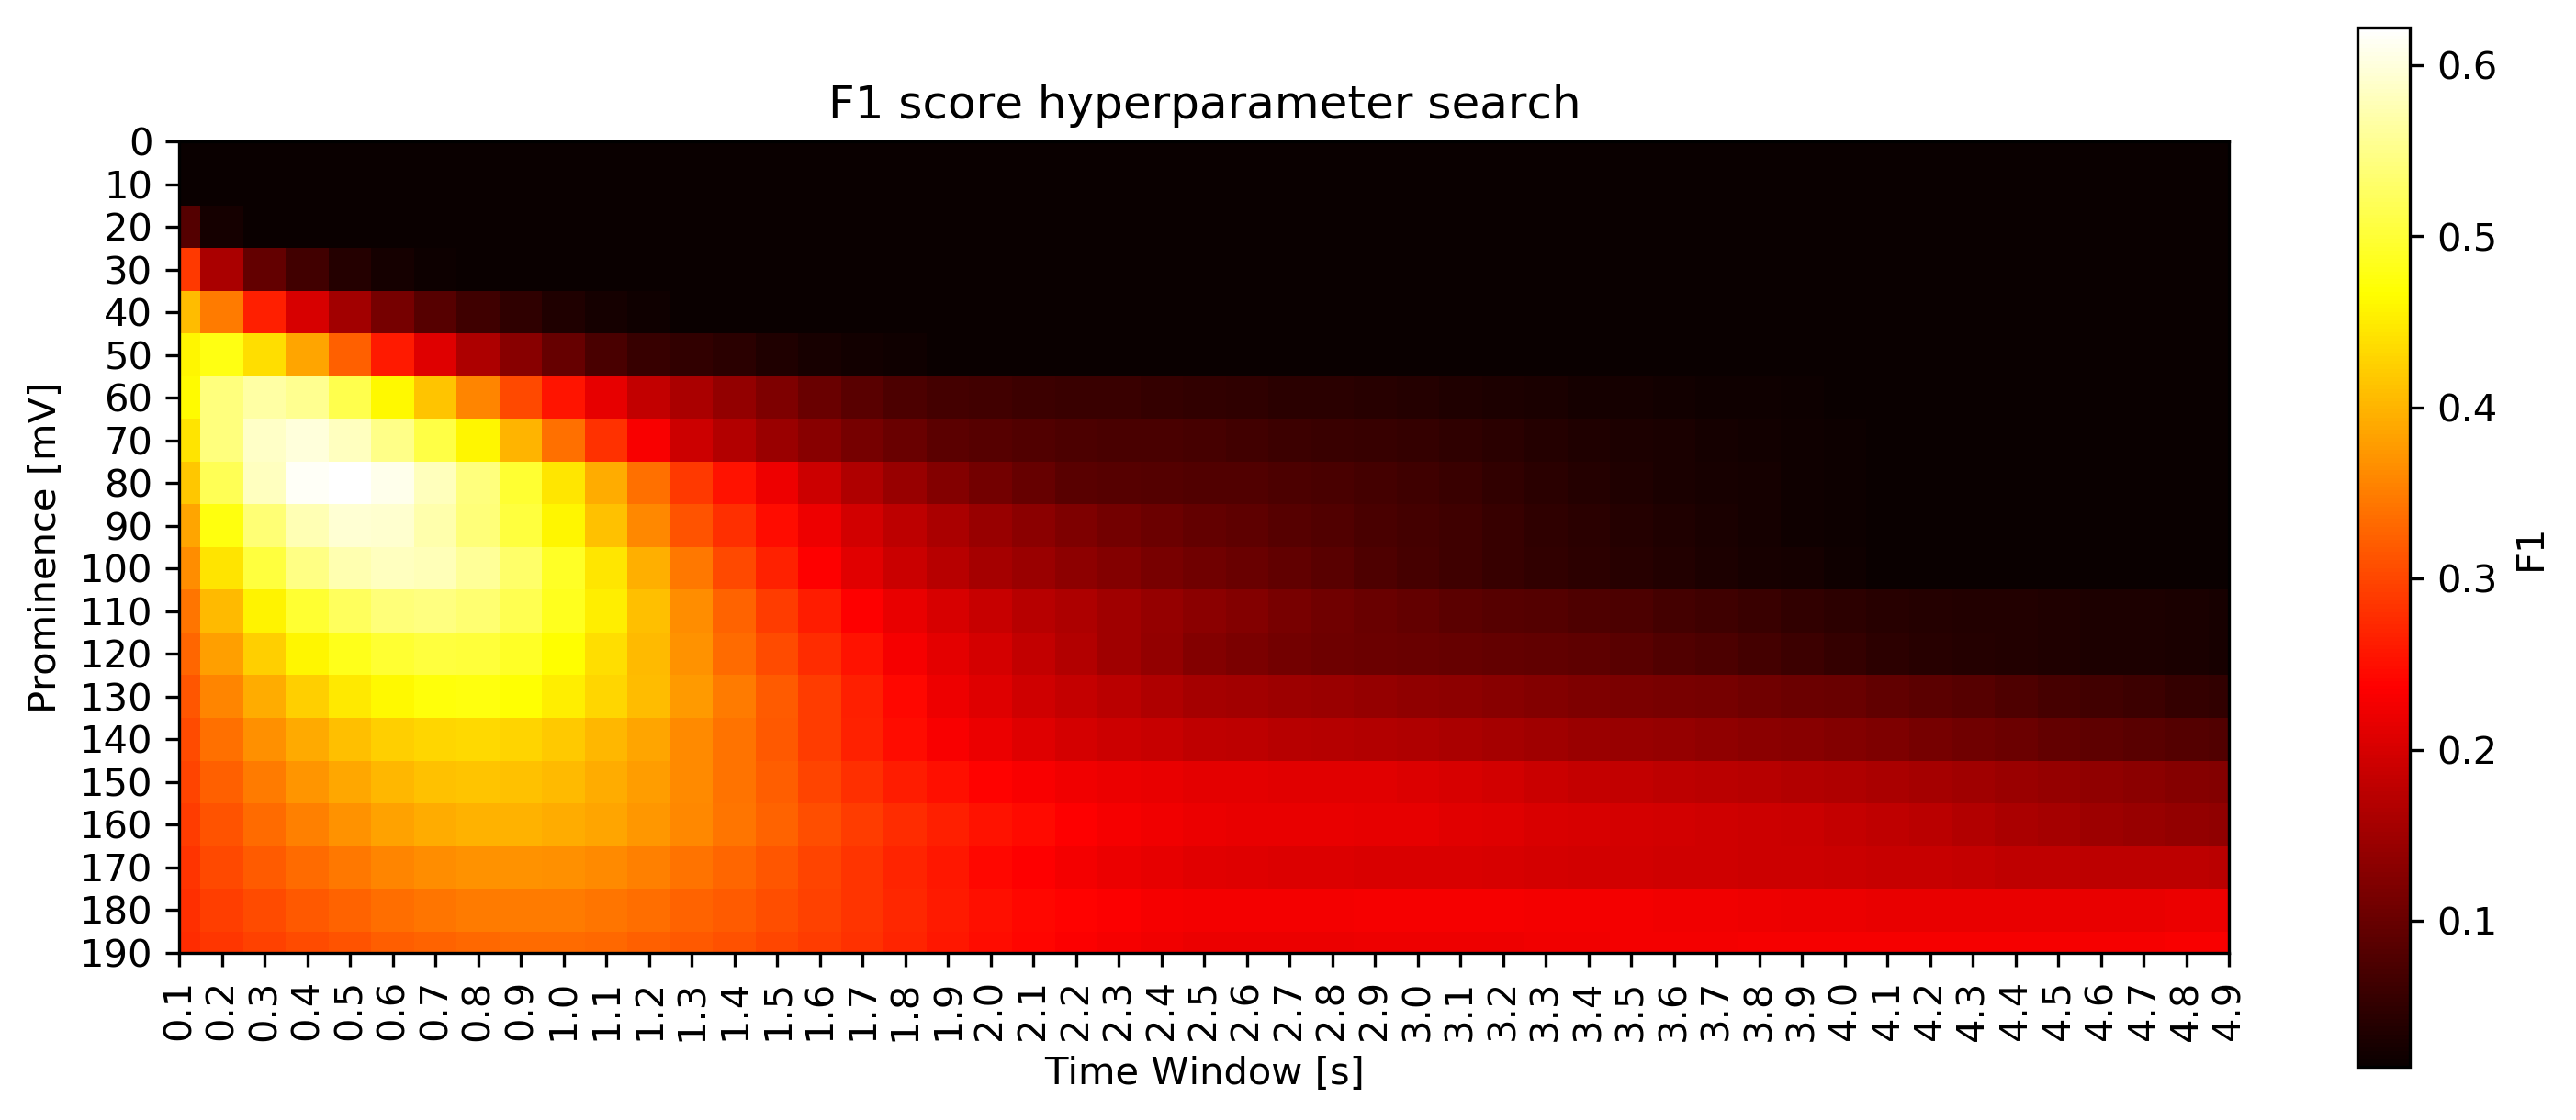

In [140]:
plt.figure(figsize=(12,5), dpi=300)
plt.imshow(F1_t, cmap='hot')
plt.ylabel("Prominence [mV]"); plt.xlabel("Time Window [s]")
plt.yticks(range(thr_space.shape[0]),thr_space)
plt.xticks(range(int(time_window_space.shape[0]/1)),np.round(time_window_space[::1]/10,1), rotation=90)
plt.xlim(1,time_window_space.shape[0]-1)
cb = plt.colorbar()
cb.set_label("F1")
plt.title("F1 score hyperparameter search")

In [141]:
idx_best = np.unravel_index(F1_t.argmax(), F1_t.shape)
F1_best = F1_t.max()

In [142]:
idx_best

(8, 5)

In [143]:
F1_best

0.6220472440944882

Text(0.5, 1.0, 'Sharp Wave Movement Prediction ')

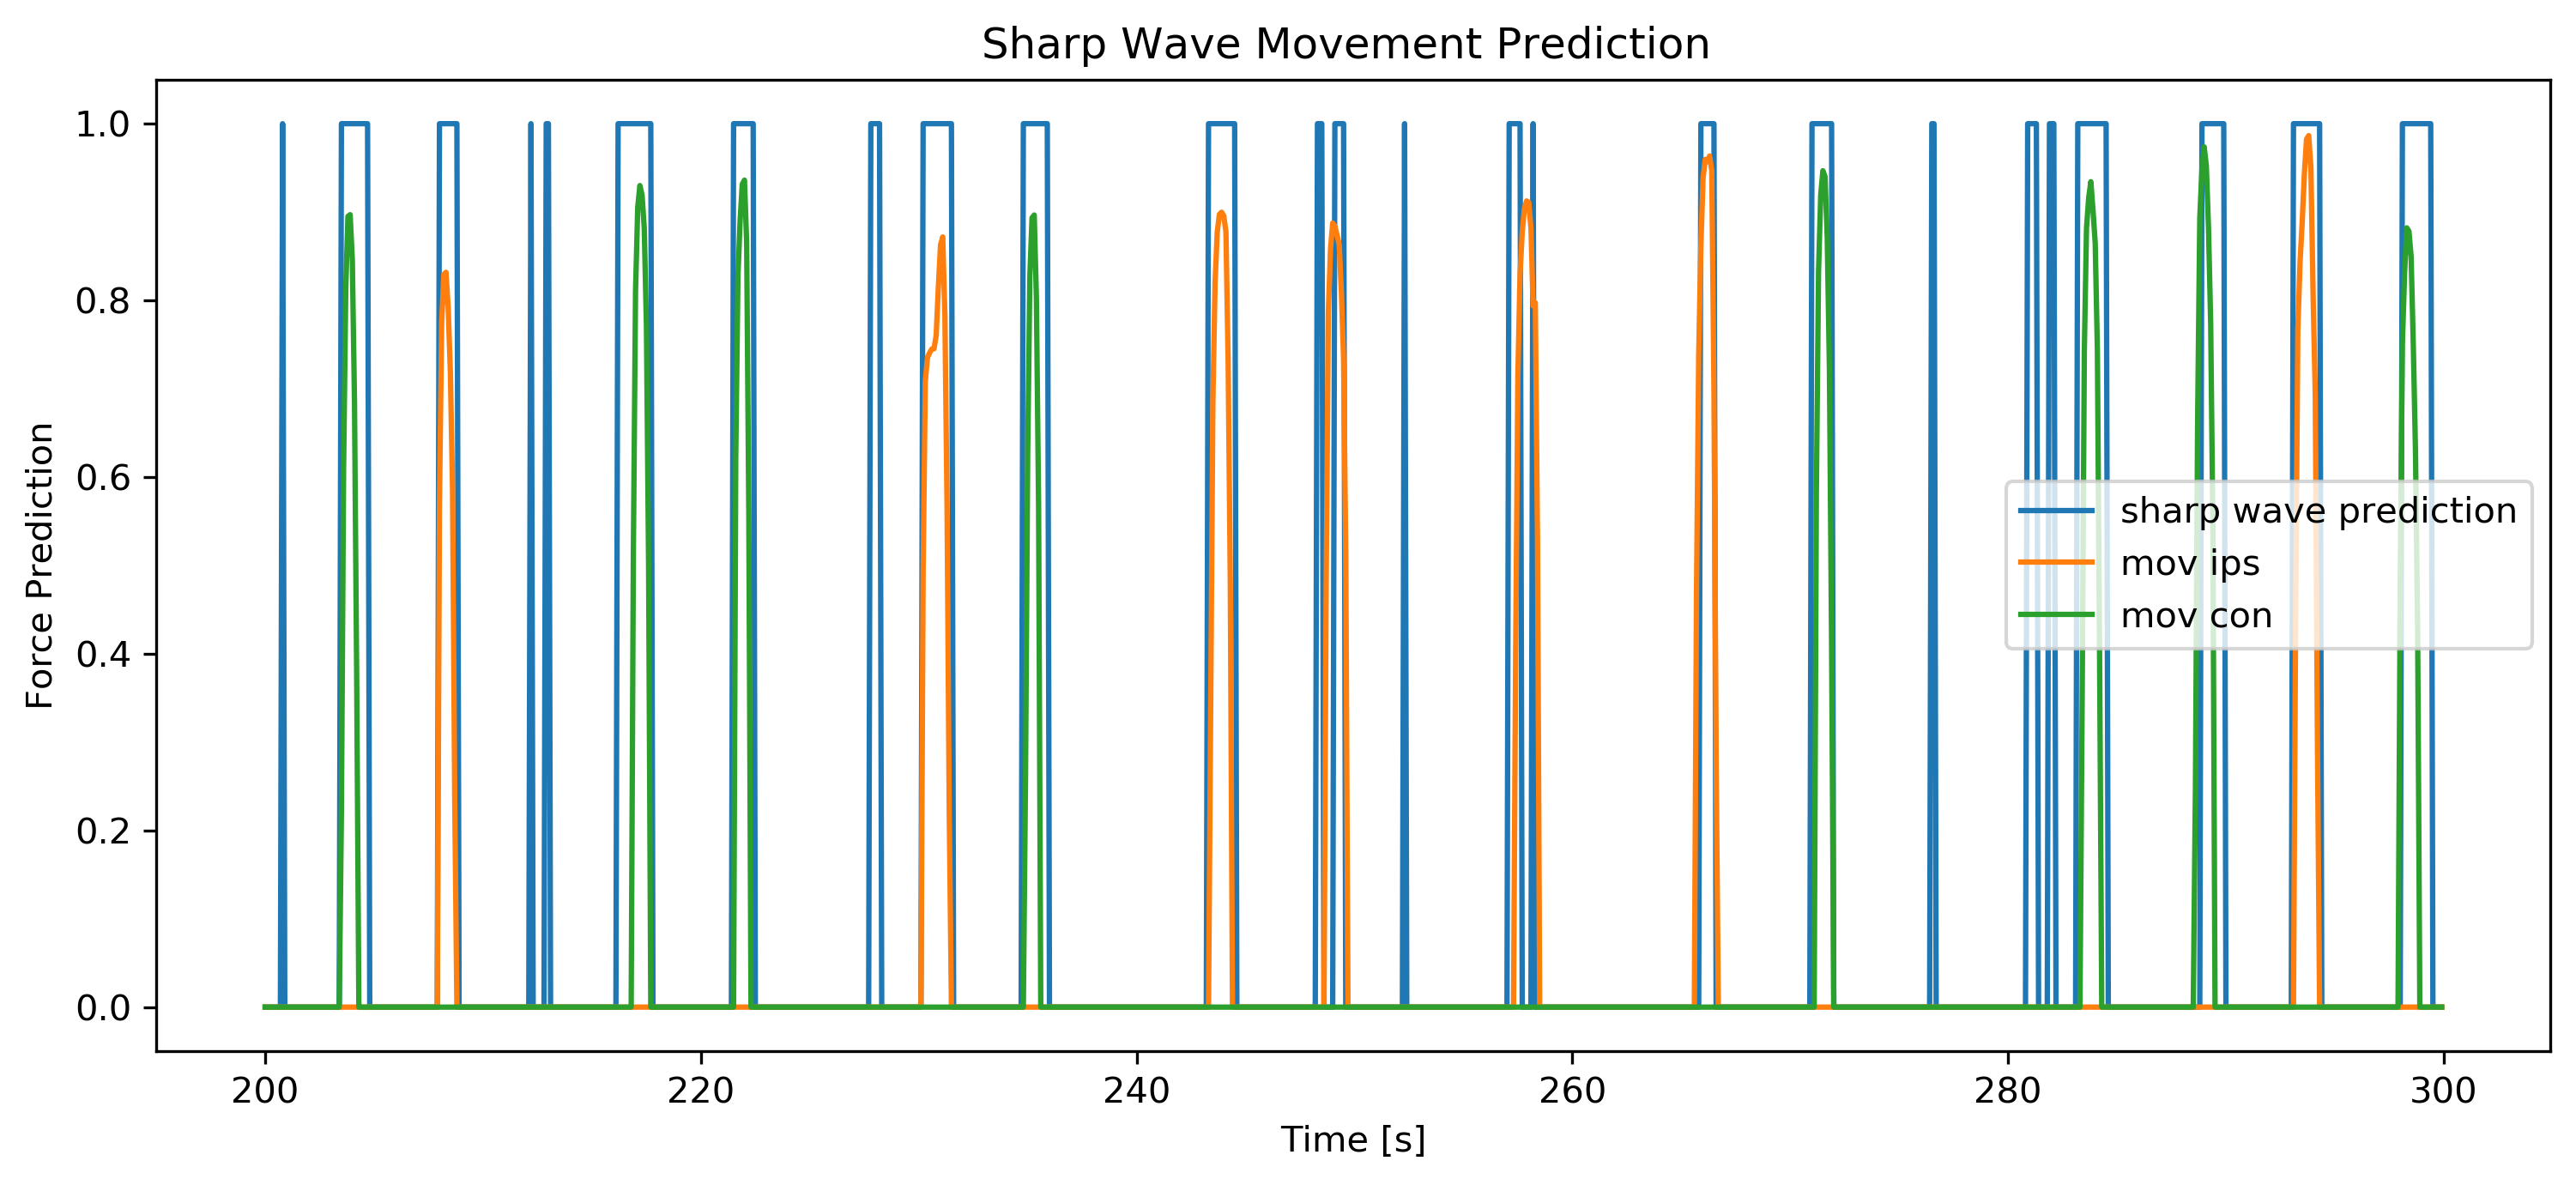

In [146]:
plt.figure(figsize=(12,5), dpi=300)
time_ = np.arange(2000, 3000, 1)/10
plt.plot(time_, pr_array[idx_best[0], idx_best[1],:][2000:3000], label="sharp wave prediction")
plt.plot(time_, res[key]["mov_ips"][::100][2000:3000], label="mov ips")
plt.plot(time_, label[2000:3000], label="mov con")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Force Prediction")
plt.title("Sharp Wave Movement Prediction ")

### write a generator for getting data 

In [152]:
files_combined = os.listdir(PATH_COMBINED)
files_troughs = os.listdir(PATH_TROUGHS)

In [167]:
def get_dat_():
    for loc in ["ECOG", "STN"]:
        for sub in subjects:
            files = np.sort(np.array([f for f in files_troughs if loc in f and sub in f]))
            for f_idx, f in enumerate(files):
                df_TROUGHS = np.load(os.path.join(PATH_TROUGHS, files[f_idx]), allow_pickle=True)
                res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][f_idx]), allow_pickle=True)
                
                key = f[f.find("ch_")+3:f.find(".p")] # from syntax: 'sub_000_ch_ECOG_RIGHT_0.p'
                
                mov_con = res[key]["mov_con"]
                mov_ips = res[key]["mov_ips"]
                print("loc: "+str(loc))
                print("sub: "+str(sub))
                print("f: "+str(f))
                
                yield sub, loc, key, mov_con, mov_ips, df_TROUGHS

In [168]:
gen_ = get_dat_()

In [169]:
(sub, loc, key, mov_con, mov_ips, df_TROUGHS, res, files) = next(gen_)

loc: ECOG
sub: 000
f: sub_000_ch_ECOG_RIGHT_0.p


In [170]:
res.keys()

dict_keys(['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2'])

In [171]:
files

array(['sub_000_ch_ECOG_RIGHT_0.p', 'sub_000_ch_ECOG_RIGHT_1.p',
       'sub_000_ch_ECOG_RIGHT_2.p', 'sub_000_ch_ECOG_RIGHT_3.p',
       'sub_000_ch_ECOG_RIGHT_4.p', 'sub_000_ch_ECOG_RIGHT_5.p'],
      dtype='<U25')

In [178]:
files[0][files[0].find("ch_")+3:files[0].find(".p")]

'ECOG_RIGHT_0'

In [179]:
files[0]

'sub_000_ch_ECOG_RIGHT_0.p'

In [181]:
[f for f in files_combined if sub in f]

['sub_000_comb.p']

In [180]:
res = np.load(os.path.join(PATH_COMBINED, [f for f in files_combined if sub in f][f_idx]), allow_pickle=True)

NameError: name 'f_idx' is not defined

In [182]:
dict_ = {
    "p": 0
}

In [183]:
np.save("mp.npy", dict_)

In [184]:
import multiprocessing

In [185]:
multiprocessing.Pool?